# Test thresholds for CAM binarization and Pattern Mining

Try all classical thresholds from skimage to detect points that are relevant for classification in CAMs. Stripes of
relevant points are then used for pattern mining.


## Conclusions

* Threshold Li returns most consistent results

* Non-binarized CAMs can be unstable and spread to the whole signal (but the non-specific part). This is not desirable for identifying specific regions.

* Guided Backpropagation alone doesn't return what is expected.

* Guided-CAM can be an interesting alternative as they tend to constrain patterns a bit more. Also seem to increase specificity in the bivariate case.

*

#### Imports and functions definitions

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from load_data import DataProcesser
from results_model import top_classification_perclass
from pattern_utils import extend_segments, longest_segments
from class_dataset import myDataset, ToTensor, RandomCrop
from dtaidistance import dtw, clustering
from models import ConvNetCam
import matplotlib.pyplot as plt
from pattern_utils import create_cam, create_gbackprop
from skimage.filters import threshold_isodata, threshold_li, threshold_mean, threshold_minimum,\
    threshold_otsu, threshold_triangle, threshold_yen
import pandas as pd
from matplotlib.colors import Colormap

def all_threshs(x):
    iso = threshold_isodata(x)
    iso = 0
    li = threshold_li(x)
    mean = threshold_mean(x)
    try:
        mini = threshold_minimum(x)
    except:
        mini = 0
    otsu = threshold_otsu(x)
    tri = threshold_triangle(x)
    yen = threshold_yen(x)
    return {'isodata': iso, 'li': li, 'mean': mean, 'minimum': mini, 'otsu': otsu, 'triangle': tri, 'yen': yen}


def both_cams(id_traj, meas_var, patt_percmax_cam=0.5):
    series_numpy = np.array(df.loc[df['ID'] == id_traj][meas_var]).astype('float').squeeze()
    if len(meas_var) >= 2:
        series_numpy = series_numpy.transpose()
    series_tensor = torch.tensor(series_numpy)
    class_trajectory = df.loc[df['ID'] == id_traj]['Class'].iloc[0]  # repeated value through all series
    class_label = classes[class_trajectory]
    cam = create_cam(model, array_series=series_tensor, feature_layer='features',
                         device=device, clip=0, target_class=class_trajectory)
    thresh = np.max(cam) * patt_percmax_cam
    bincam = np.where(cam >= thresh, 1, 0)
    return cam, bincam, thresh, series_numpy


def thresh_plot(xtupl, threshs, title):
    plt.close()
    plt.figure(figsize=(8,10), dpi=90)
    ax = plt.subplot(5,2,1)
    plt.hist(xtupl[0])
    plt.axvline(xtupl[2], linestyle='--', color='r')
    ax.xaxis.tick_top()
    #ax.set_xticklabels([])
    plt.title('Histogram of raw CAM')
    ax = plt.subplot(5,2,2)
    plt.plot(np.arange(len(xtupl[3])), xtupl[3])
    plt.scatter(np.arange(len(xtupl[3])), xtupl[3], c=xtupl[1])
    ax.set_xticklabels([])
    plt.title('Perc of max CAM')
    iplot = 3
    for thresh in threshs:
        binarized = np.where(xtupl[0] >= threshs[thresh], 1, 0)
        ax = plt.subplot(5,2,iplot)
        plt.plot(np.arange(len(xtupl[3])), xtupl[3])
        plt.scatter(np.arange(len(xtupl[3])), xtupl[3], c=binarized)
        if iplot != 9:
            ax.set_xticklabels([])
        plt.title(thresh)
        iplot += 1
    ax = plt.subplot(5,2,10)
    plt.annotate(title, xy=(0.5, 0.5), xycoords='axes fraction')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()
    
    
def thresh_plot2D(xtupl, threshs, title):
    plt.close()
    plt.figure(figsize=(8,10), dpi=90)
    ax = plt.subplot(5,2,1)
    plt.hist(xtupl[0].flatten())
    plt.axvline(xtupl[2], linestyle='--', color='r')
    ax.xaxis.tick_top()
    #ax.set_xticklabels([])
    plt.title('Histogram of raw CAM')
    ax = plt.subplot(5,2,2)
    plt.plot(np.arange(len(xtupl[3][0,:])), xtupl[3][0,:])
    plt.scatter(np.arange(len(xtupl[3][0,:])), xtupl[3][0,:], c=xtupl[1][0,:])
    plt.plot(np.arange(len(xtupl[3][1,:])), xtupl[3][1,:])
    plt.scatter(np.arange(len(xtupl[3][1,:])), xtupl[3][1,:], c=xtupl[1][1,:])
    ax.set_xticklabels([])
    plt.title('Perc of max CAM')
    iplot = 3
    for thresh in threshs:
        binarized = np.where(xtupl[0] >= threshs[thresh], 1, 0)
        ax = plt.subplot(5,2,iplot)
        plt.plot(np.arange(len(xtupl[3][0,:])), xtupl[3][0,:])
        plt.scatter(np.arange(len(xtupl[3][0,:])), xtupl[3][0,:], c=binarized[0,:])
        plt.plot(np.arange(len(xtupl[3][1,:])), xtupl[3][1,:])
        plt.scatter(np.arange(len(xtupl[3][1,:])), xtupl[3][1,:], c=binarized[1,:])
        if iplot != 9:
            ax.set_xticklabels([])
        plt.title('{}: {}'.format(thresh, round(threshs[thresh], 3)))
        iplot += 1
    ax = plt.subplot(5,2,10)
    plt.annotate(title, xy=(0.5, 0.5), xycoords='axes fraction')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


## With synthetic data (2 first classes, mixtures of Gaussians without 2nd channel)

In [2]:
data_file = '../data/synthetic_len750.zip'
model_file = '../models/FRST_classAB/2019-06-04-18:06:45_synthetic_len750.pytorch'
selected_set = 'both'
meas_var = ['FRST']

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
model = torch.load(model_file)
model.eval()
model.double()
model.batch_size = 1
model = model.to(device)

data = DataProcesser(data_file)
data.subset(sel_groups=meas_var, start_time=0, end_time=750)
data.get_stats()
data.dataset = data.dataset[data.dataset[data.col_class].isin([0,1])]
#data.process(method='center_train', independent_groups=True)  # do here and not in loader so can use in df
#data.crop_random(model.length, ignore_na_tails=True)
data.split_sets(which='dataset')
classes = tuple(data.classes.iloc[:, 1])
classes=('A', 'B')

# Random crop before to keep the same in df as the ones passed in the model
if selected_set == 'validation':
    selected_data = myDataset(dataset=data.validation_set,
                              transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                  ToTensor()]))
    df = data.validation_set
elif selected_set == 'training':
    selected_data = myDataset(dataset=data.train_set,
                              transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                  ToTensor()]))
    df = data.train_set
elif selected_set == 'both':
    try:
        selected_data = myDataset(dataset=data.dataset_cropped,
                                  transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                      ToTensor()]))
        df = data.dataset_cropped
    except:
        selected_data = myDataset(dataset=data.dataset,
                                  transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                      ToTensor()]))
        df = data.dataset

data_loader = DataLoader(dataset=selected_data,
                         batch_size=1,
                         shuffle=True,
                         num_workers=4)
# Dataframe used for retrieving trajectories
df = pd.wide_to_long(df, stubnames=meas_var, i=[data.col_id, data.col_class], j='Time', sep='_', suffix='\d+')
df = df.reset_index()  # wide_to_long creates a multi-level Index, reset index to retrieve indexes in columns
df.rename(columns={data.col_id: 'ID', data.col_class: 'Class'}, inplace=True)
df['ID'] = df['ID'].astype('U32')
del data  # free memory

#df.columns = ['ID', 'Class'] + [i+1 for i in range(len(df.columns)-2)]
#df = df.melt(['ID', 'Class'])
#df.rename(columns={'variable': 'Time', 'value': 'Value'}, inplace=True)
#df['ID'] = df['ID'].astype('U32')
#del data  # free memory

/home/marc/Dropbox/Work/TSclass_GF/load_data.py:426: UserWarning: Data were not processed.
  warnings.warn('Data were not processed.')


In [3]:
ids = ['A_2688', 'A_7540', 'A_7619', 'A_8594', 'B_1145', 'B_3652', 'B_6453', 'B_4460']
cams = {i:both_cams(i, meas_var) for i in ids}

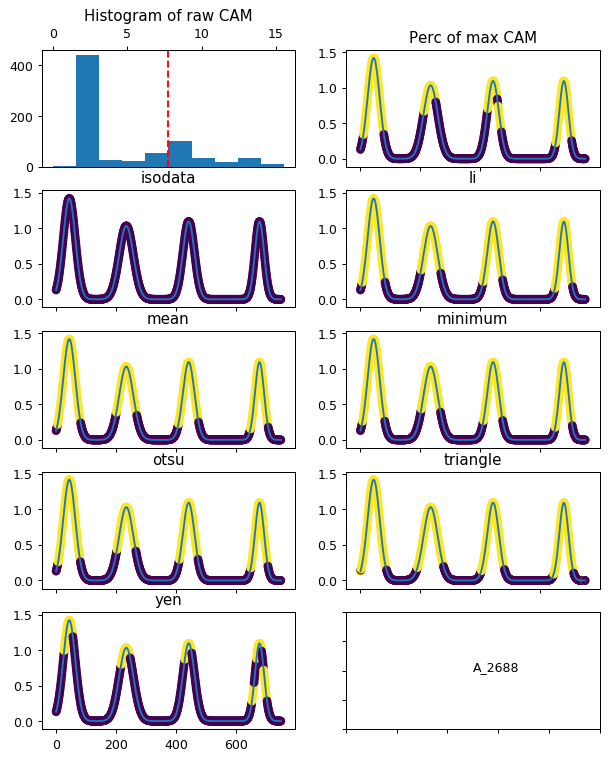

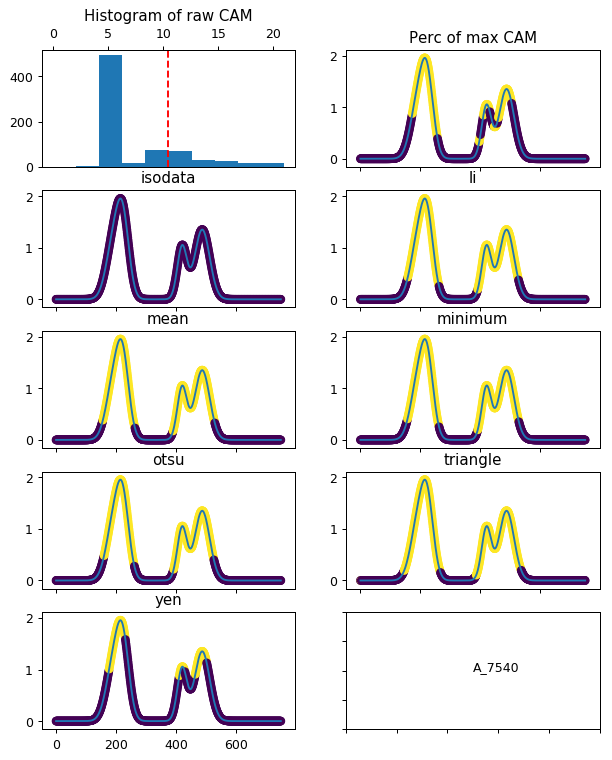

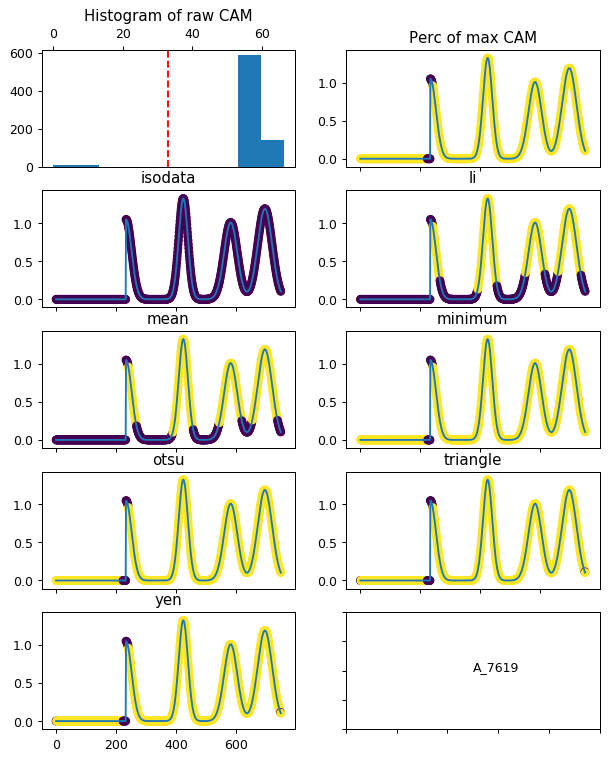

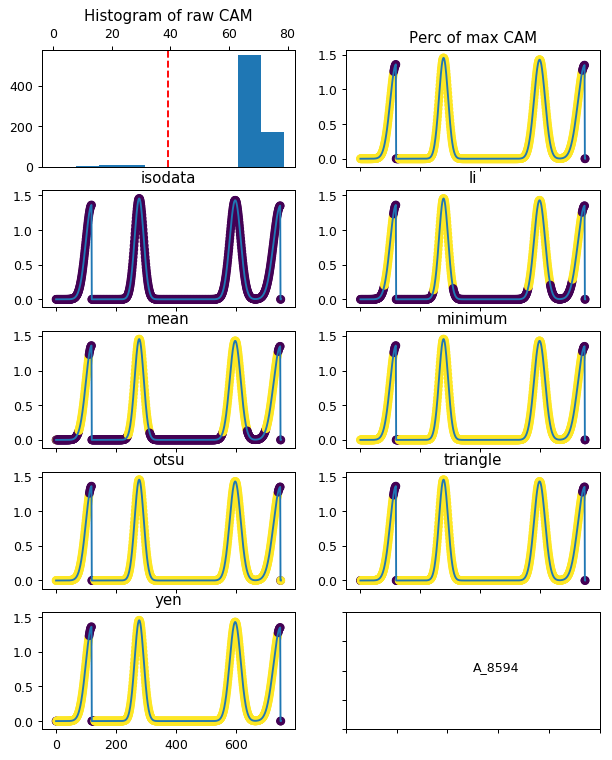

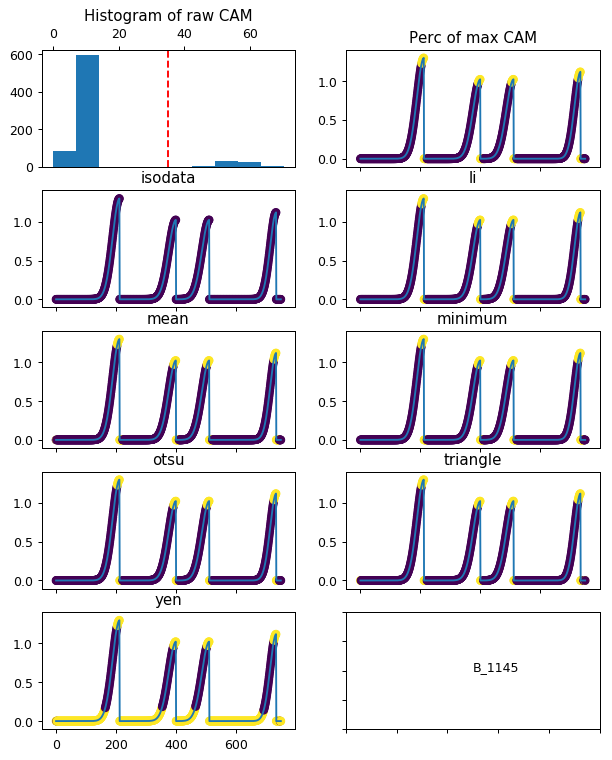

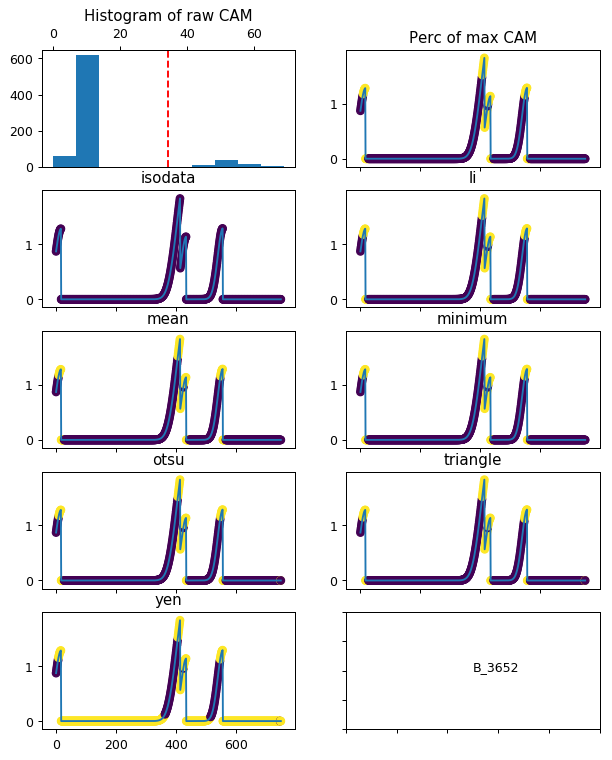

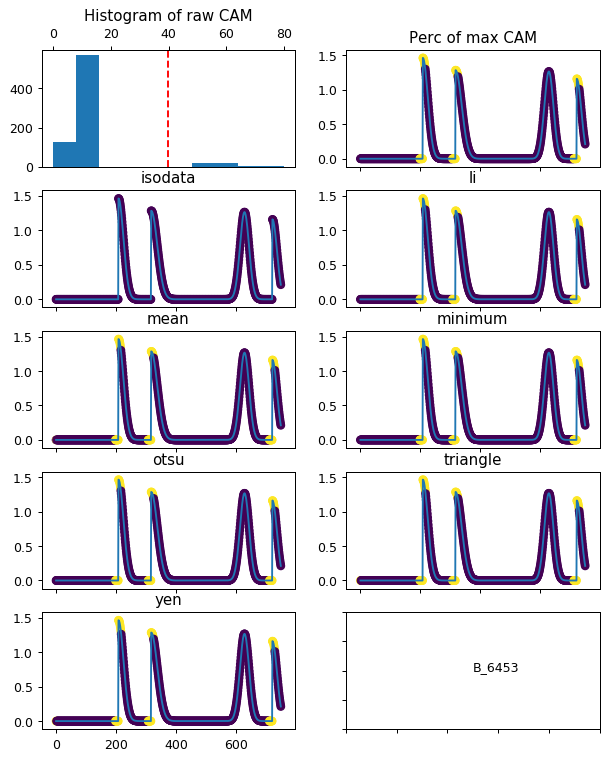

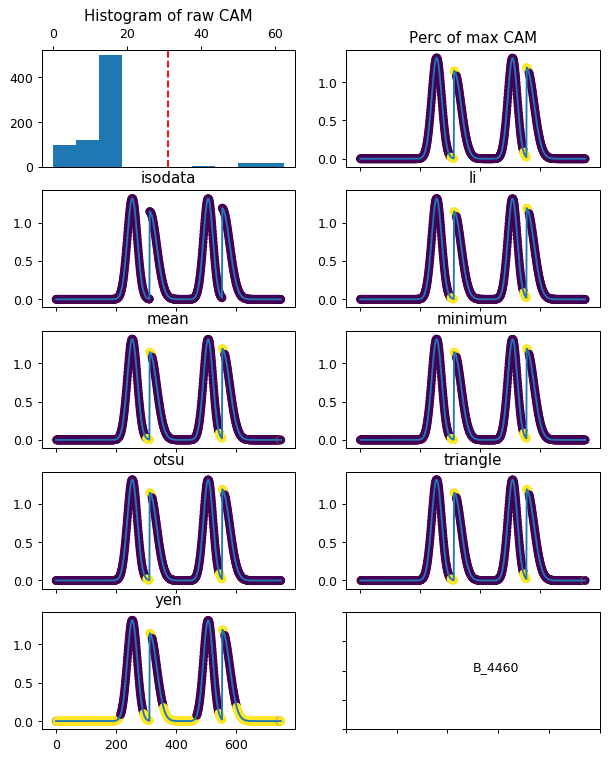

In [4]:
for id in ids:
    thresh_plot(cams[id], all_threshs(cams[id][0]), id)

### Results class AB

The thresholds li and mean appear most robust.


### Comparison with guided backprop and guided-CAM (Li threshold)


In [5]:
def get_saliencies(id_traj, meas_var, patt_percmax_sal=0.5, use_abs = True):
    series_numpy = np.array(df.loc[df['ID'] == id_traj][meas_var]).astype('float').squeeze()
    if len(meas_var) >= 2:
        series_numpy = series_numpy.transpose()
    series_tensor = torch.tensor(series_numpy)
    class_trajectory = df.loc[df['ID'] == id_traj]['Class'].iloc[0]  # repeated value through all series
    class_label = classes[class_trajectory]
    cam = create_cam(model, array_series=series_tensor, feature_layer='features',
                         device=device, clip=0, target_class=class_trajectory)
    backprop = create_gbackprop(model=model, array_series=series_tensor,
                         device=device, clip=0, target_class=class_trajectory)
    guided_cam = cam * backprop
    if use_abs:
        guided_cam = np.abs(guided_cam)
        
    cam = np.where(cam >= threshold_li(cam), 1, 0)
    backprop = np.where(backprop >= threshold_li(backprop), 1, 0)
    guided_cam = np.where(guided_cam >= threshold_li(guided_cam), 1, 0)
    return cam, backprop, guided_cam, series_numpy, id_traj


def get_saliencies_raw(id_traj, meas_var, patt_percmax_sal=0.5, use_abs = True):
    series_numpy = np.array(df.loc[df['ID'] == id_traj][meas_var]).astype('float').squeeze()
    if len(meas_var) >= 2:
        series_numpy = series_numpy.transpose()
    series_tensor = torch.tensor(series_numpy)
    class_trajectory = df.loc[df['ID'] == id_traj]['Class'].iloc[0]  # repeated value through all series
    class_label = classes[class_trajectory]
    cam = create_cam(model, array_series=series_tensor, feature_layer='features',
                         device=device, clip=0, target_class=class_trajectory)
    backprop = create_gbackprop(model=model, array_series=series_tensor,
                         device=device, clip=0, target_class=class_trajectory)
    guided_cam = cam * backprop
    if use_abs:
        guided_cam = np.abs(guided_cam)
        
    return cam, backprop, guided_cam, series_numpy, id_traj


def comp_plot1D(saliencies, id_traj):
    plt.close()
    plt.figure(figsize=(16,4), dpi=90)
    ax = plt.subplot(1,3,1)
    plt.plot(np.arange(750), saliencies[3])
    plt.scatter(np.arange(750), saliencies[3], c=saliencies[0])
    plt.title('CAM: ' + id_traj)
    # --------------------------
    ax = plt.subplot(1,3,2)
    plt.plot(np.arange(750), saliencies[3])
    plt.scatter(np.arange(750), saliencies[3], c=saliencies[1])
    plt.title('Guided Backprop')
    # --------------------------
    ax = plt.subplot(1,3,3)
    plt.plot(np.arange(750), saliencies[3])
    plt.scatter(np.arange(750), saliencies[3], c=saliencies[2])
    plt.title('Guided CAM')
    plt.show()
    
    
def comp_plot1D_raw(saliencies, id_traj):
    colormap='jet'
    plt.close()
    plt.figure(figsize=(16,4), dpi=90)
    ax = plt.subplot(1,3,1)
    plt.plot(np.arange(750), saliencies[3])
    plt.scatter(np.arange(750), saliencies[3], c=saliencies[0], cmap=colormap)
    plt.title('CAM: ' + id_traj)
    # --------------------------
    ax = plt.subplot(1,3,2)
    plt.plot(np.arange(750), saliencies[3])
    plt.scatter(np.arange(750), saliencies[3], c=saliencies[1], cmap=colormap)
    plt.title('Guided Backprop')
    # --------------------------
    ax = plt.subplot(1,3,3)
    plt.plot(np.arange(750), saliencies[3])
    plt.scatter(np.arange(750), saliencies[3], c=saliencies[2], cmap=colormap)
    plt.title('Guided CAM')
    plt.show()

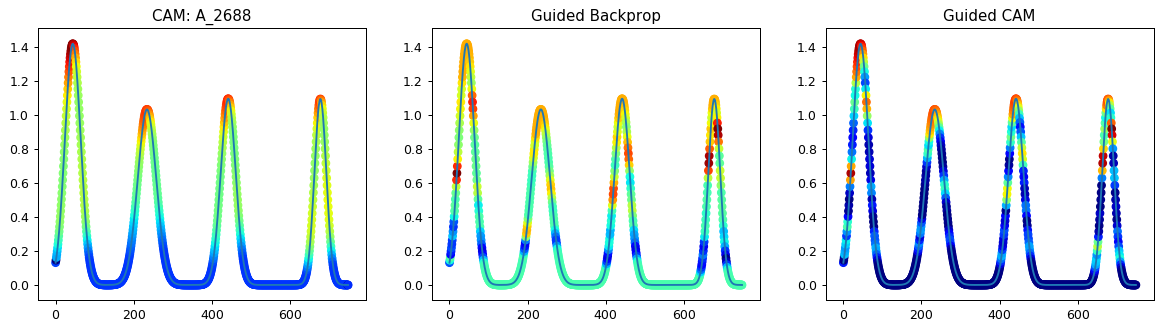

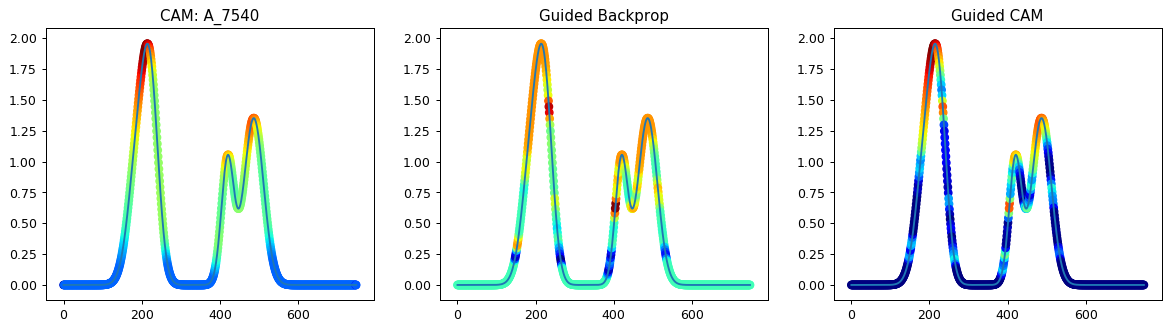

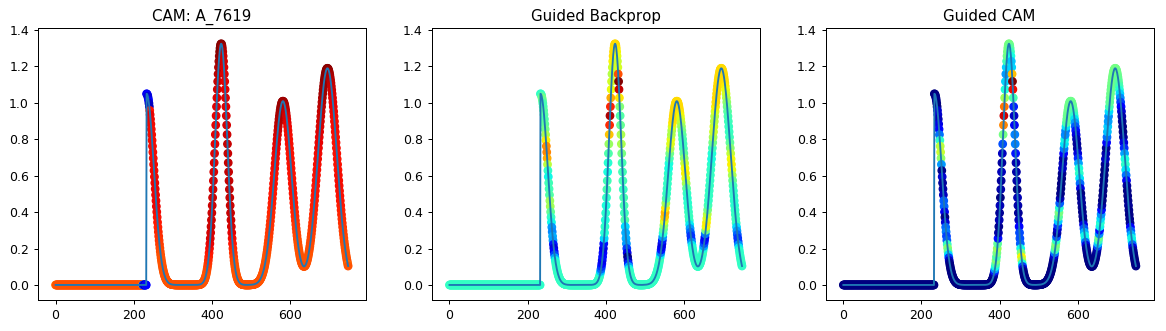

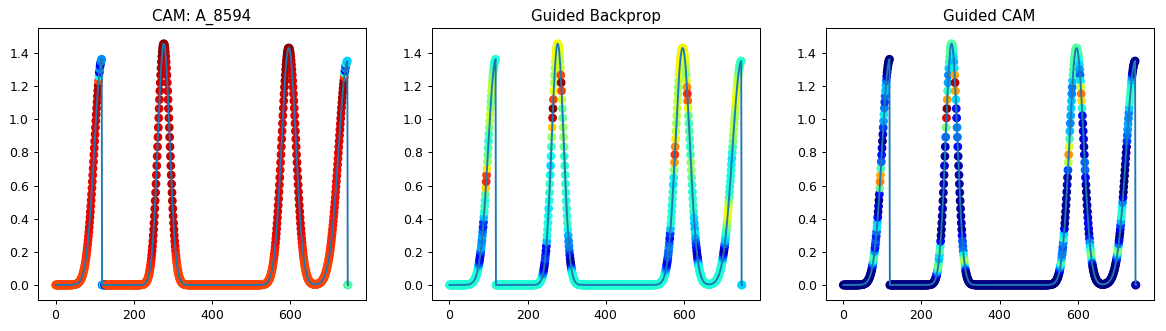

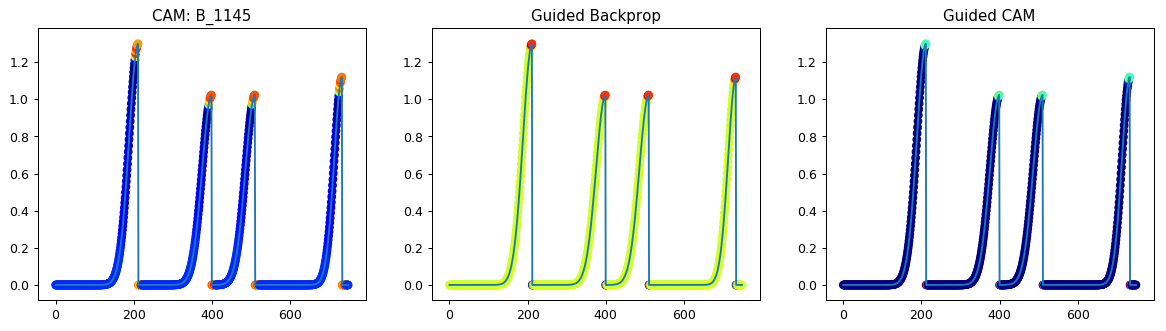

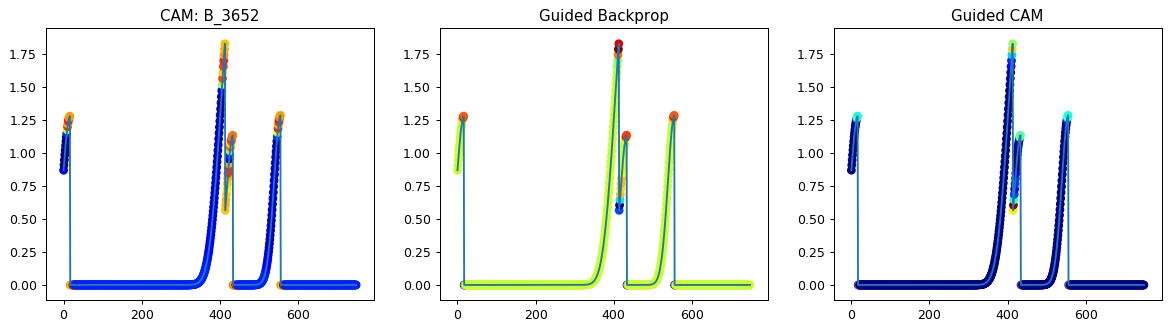

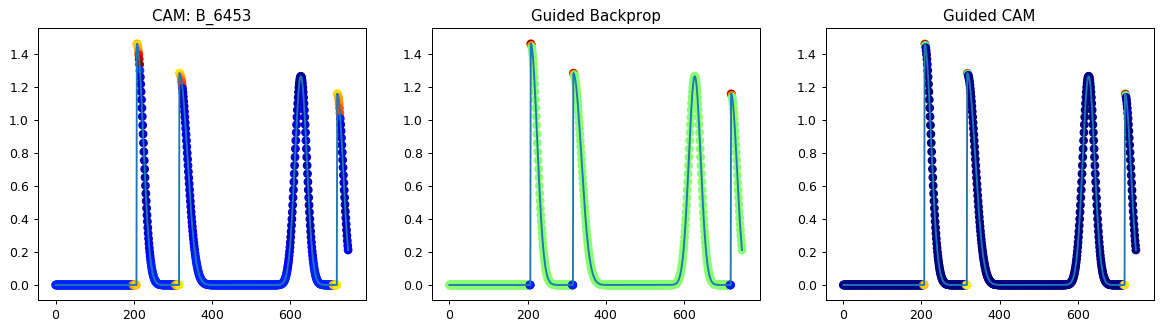

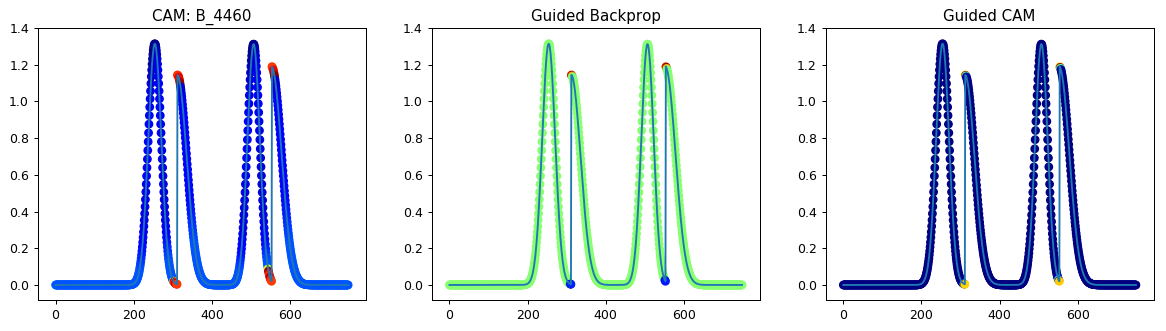

In [6]:
ids = ['A_2688', 'A_7540', 'A_7619', 'A_8594', 'B_1145', 'B_3652', 'B_6453', 'B_4460']
saliencies = {i:get_saliencies_raw(i, meas_var, use_abs=True) for i in ids}
for id in ids:
    comp_plot1D_raw(saliencies[id], id)

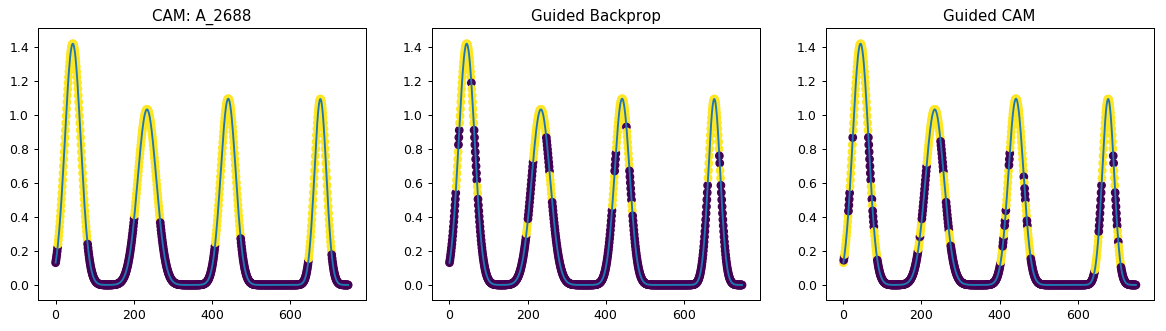

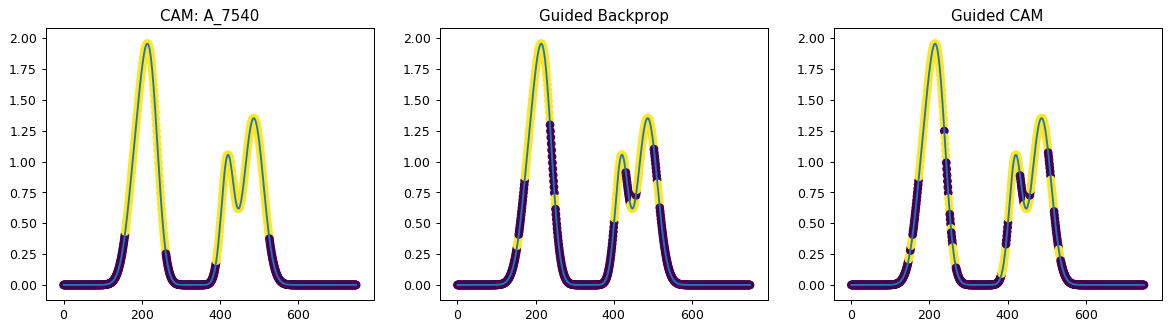

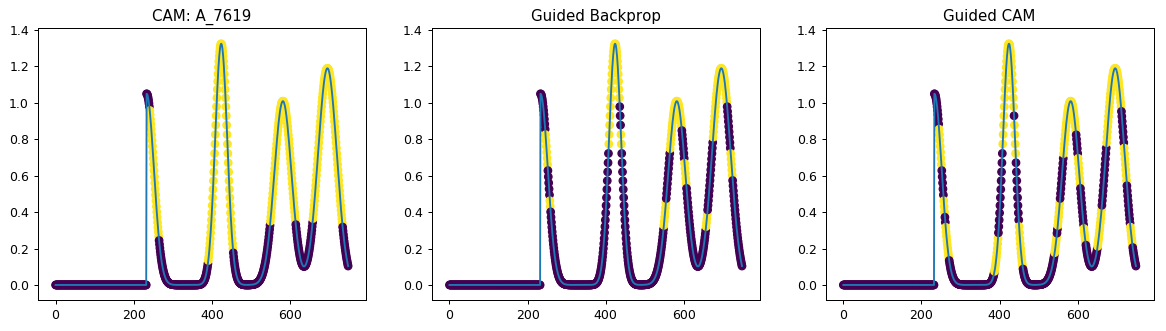

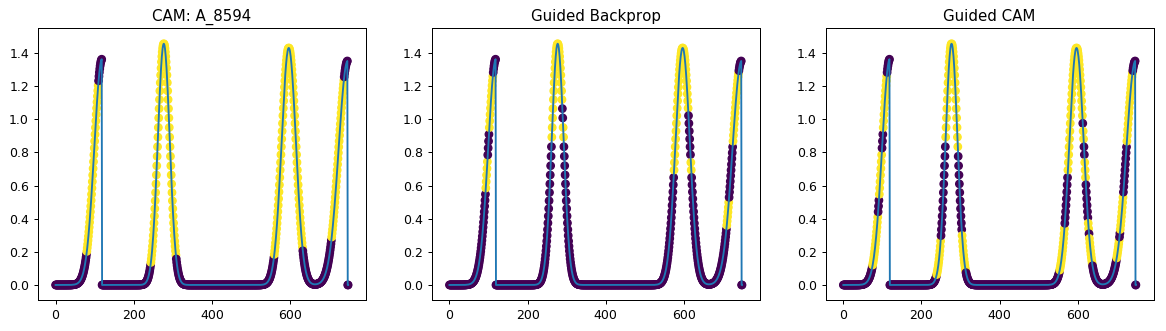

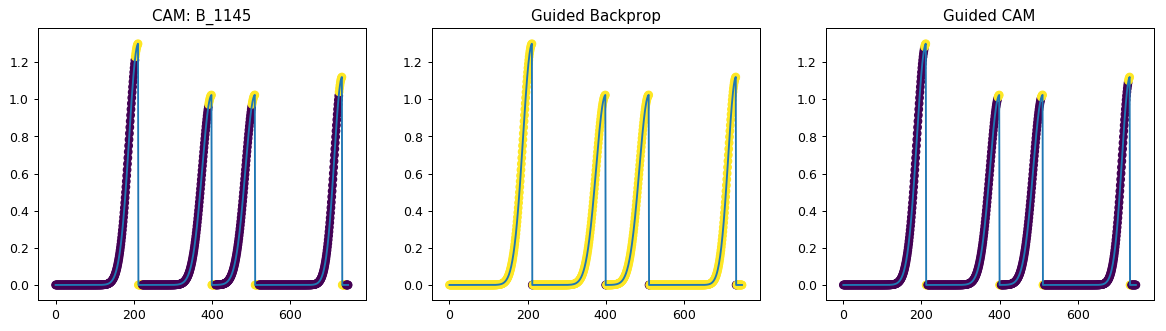

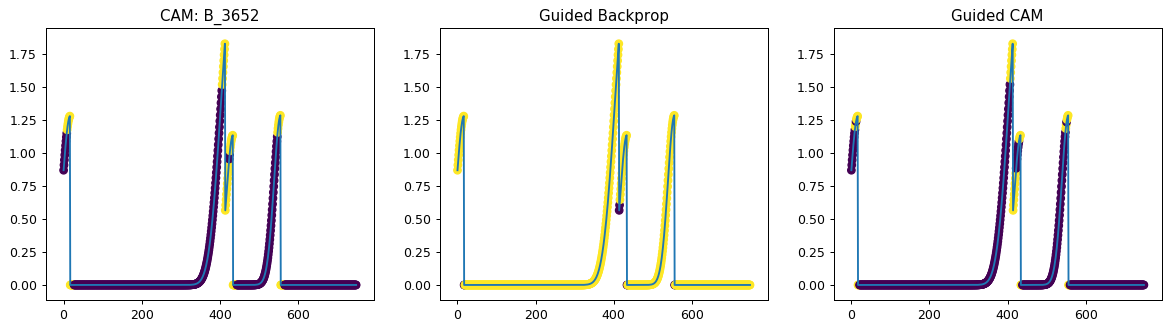

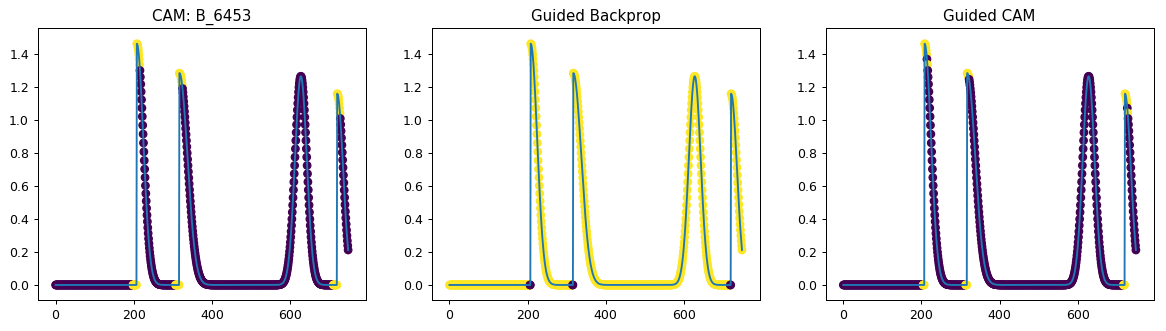

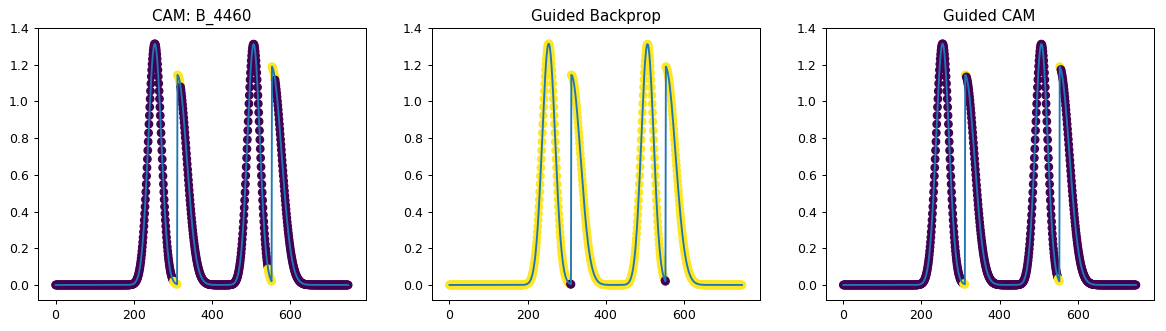

In [7]:
ids = ['A_2688', 'A_7540', 'A_7619', 'A_8594', 'B_1145', 'B_3652', 'B_6453', 'B_4460']
saliencies = {i:get_saliencies(i, meas_var, use_abs=True) for i in ids}
for id in ids:
    comp_plot1D(saliencies[id], id)

## With synthetic data (4 classes, mixtures of Gaussians with 2nd channel)

Class A: channel 1: 4 peaks with at least 2 full Gaussians; channel 2: flat
Class B: channel 1: 4 peaks with at max 2 full Gaussians; channel 2: flat
Class C: channel 1: 4 peaks with exactly 2 full Gaussians; channel 2: peak 30 points before the ones in channel 1
Class D: channel 1: 4 peaks with exactly 2 full Gaussians; channel 2: peak 30 points after the ones in channel 1

In [8]:
data_file = '../data/synthetic_len750.zip'
model_file = '../models/FRST_SCND/2019-06-17-15:47:03_synthetic_len750.pytorch'
selected_set = 'both'
meas_var = ['FRST', 'SCND']

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
model = torch.load(model_file)
model.eval()
model.double()
model.batch_size = 1
model = model.to(device)

data = DataProcesser(data_file)
data.subset(sel_groups=meas_var, start_time=0, end_time=750)
#data.dataset = data.dataset[data.dataset[data.col_class].isin([0,1])]
data.get_stats()
#data.process(method='center_train', independent_groups=True)  # do here and not in loader so can use in df
#data.crop_random(model.length, ignore_na_tails=True)
data.split_sets(which='dataset')
classes = tuple(data.classes.iloc[:, 1])
#classes = ('A', 'B')

# Random crop before to keep the same in df as the ones passed in the model
if selected_set == 'validation':
    selected_data = myDataset(dataset=data.validation_set,
                              transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                                            ToTensor()]))
    df = data.validation_set
elif selected_set == 'training':
    selected_data = myDataset(dataset=data.train_set,
                              transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                                            ToTensor()]))
    df = data.train_set
elif selected_set == 'both':
    try:
        selected_data = myDataset(dataset=data.dataset_cropped,
                                  transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                                                ToTensor()]))
        df = data.dataset_cropped
    except:
        selected_data = myDataset(dataset=data.dataset,
                                  transform=transforms.Compose([#RandomCrop(output_size=model.length, ignore_na_tails=True),
                                                                ToTensor()]))
        df = data.dataset

data_loader = DataLoader(dataset=selected_data,
                         batch_size=1,
                         shuffle=True,
                         num_workers=4)
# Dataframe used for retrieving trajectories. wide_to_long instead of melt because can melting per group of columns
df = pd.wide_to_long(df, stubnames=meas_var, i=[data.col_id, data.col_class], j='Time', sep='_', suffix='\d+')
df = df.reset_index()  # wide_to_long creates a multi-level Index, reset index to retrieve indexes in columns
df.rename(columns={data.col_id: 'ID', data.col_class: 'Class'}, inplace=True)
df['ID'] = df['ID'].astype('U32')
del data  # free memory

In [9]:
ids = ['A_5340', 'A_4223', 'B_1694', 'B_5119', 'C_3511', 'C_3471', 'D_3530', 'D_579']
cams = {i:both_cams(i, meas_var) for i in ids}

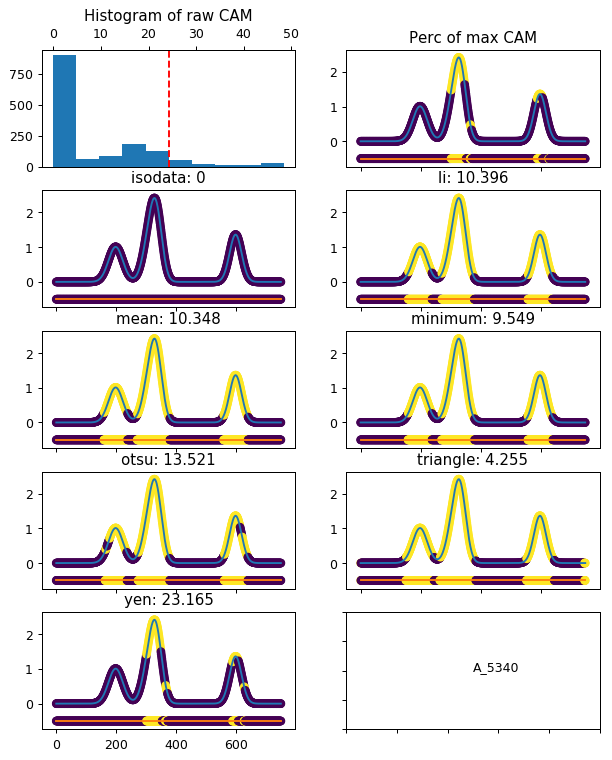

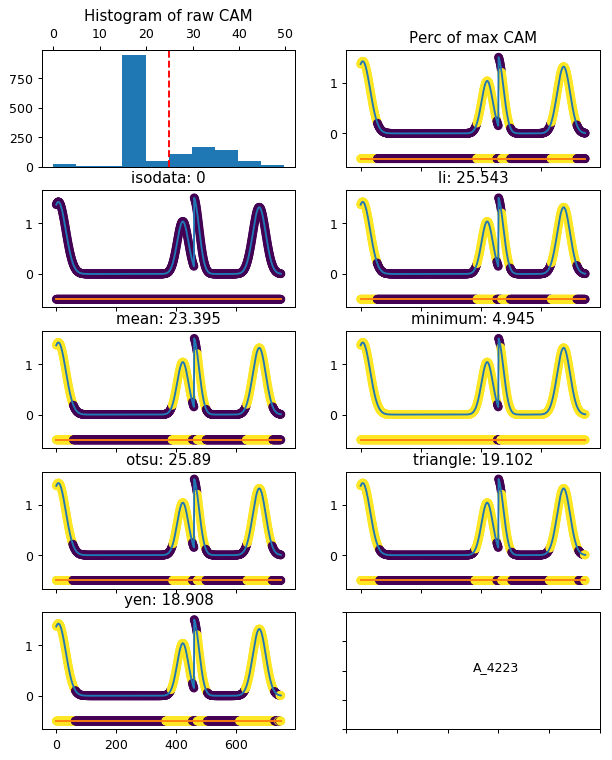

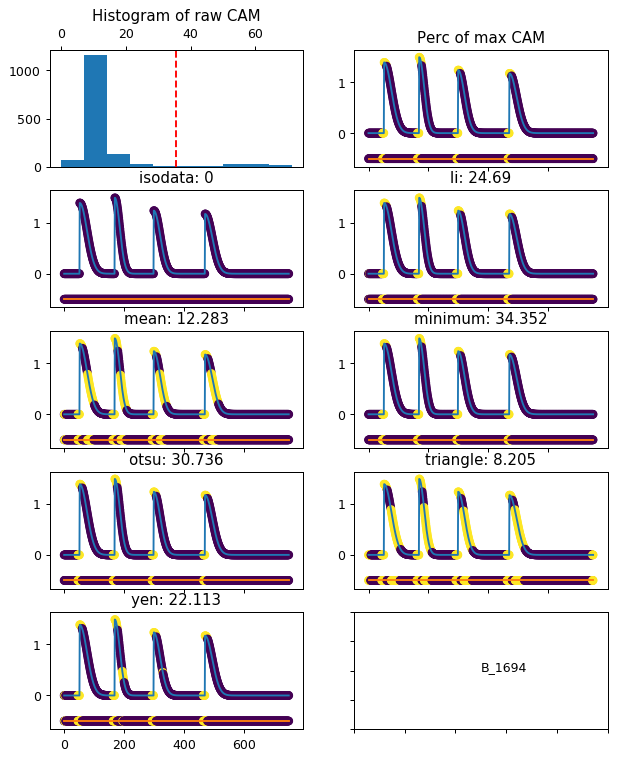

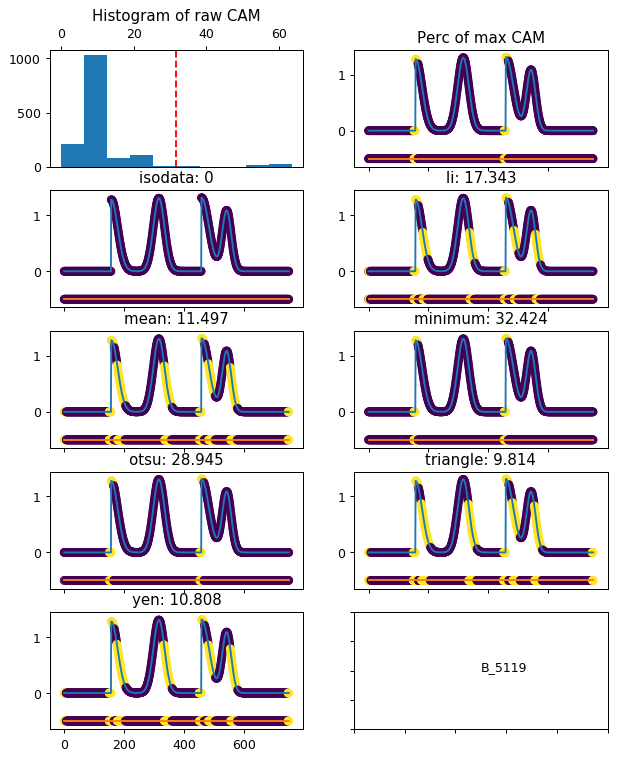

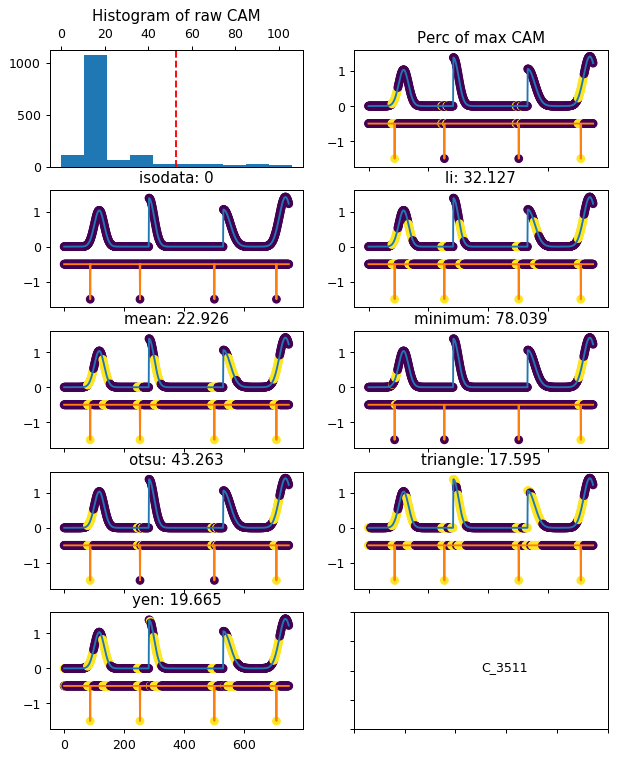

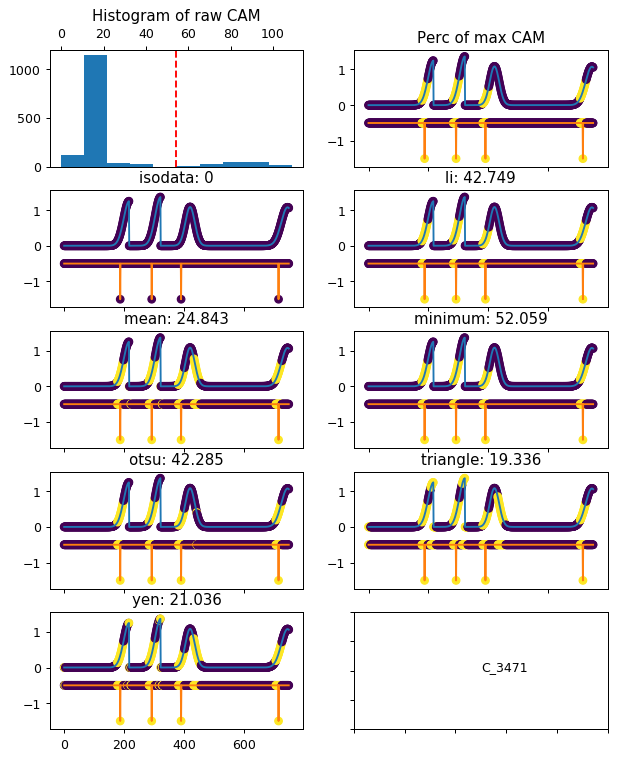

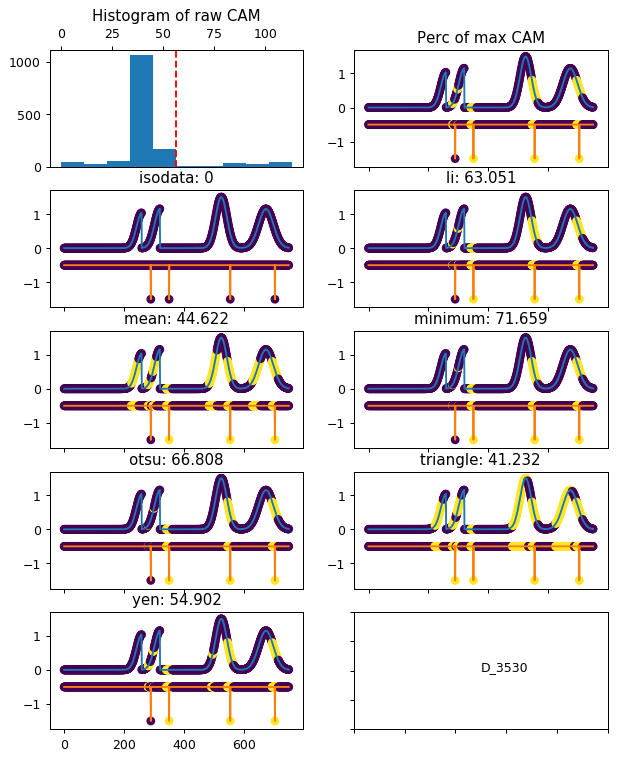

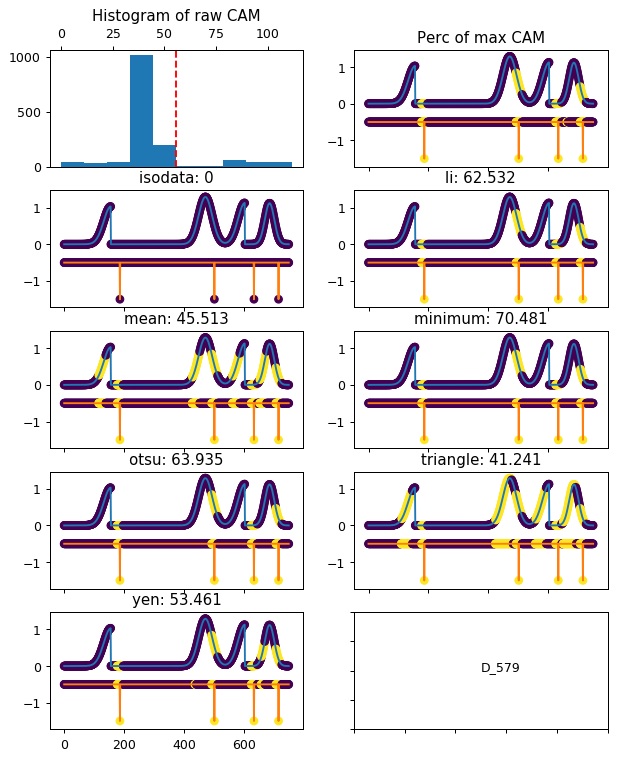

In [10]:
for id in ids:
    thresh_plot2D(cams[id], all_threshs(cams[id][0]), id)

### Results class ABCD

Threshold li seem to return slightly cleaner results especially with classes C and D.


## Test with guided backprop instead of CAM

In [11]:
def both_gbackprop(id_traj, meas_var, patt_percmax_sal=0.5, use_abs = True):
    series_numpy = np.array(df.loc[df['ID'] == id_traj][meas_var]).astype('float').squeeze()
    if len(meas_var) >= 2:
        series_numpy = series_numpy.transpose()
    series_tensor = torch.tensor(series_numpy)
    class_trajectory = df.loc[df['ID'] == id_traj]['Class'].iloc[0]  # repeated value through all series
    class_label = classes[class_trajectory]
    saliency = create_gbackprop(model=model, array_series=series_tensor,
                         device=device, clip=0, target_class=class_trajectory)
    if use_abs:
        saliency = np.abs(saliency)
    thresh = np.max(saliency) * patt_percmax_sal
    binsaliency = np.where(saliency >= thresh, 1, 0)
    return saliency, binsaliency, thresh, series_numpy

In [12]:
ids = ['A_5340', 'A_4223', 'B_1694', 'B_5119', 'C_3511', 'C_3471', 'D_3530', 'D_579']
bprops = {i:both_gbackprop(i, meas_var, use_abs=False) for i in ids}

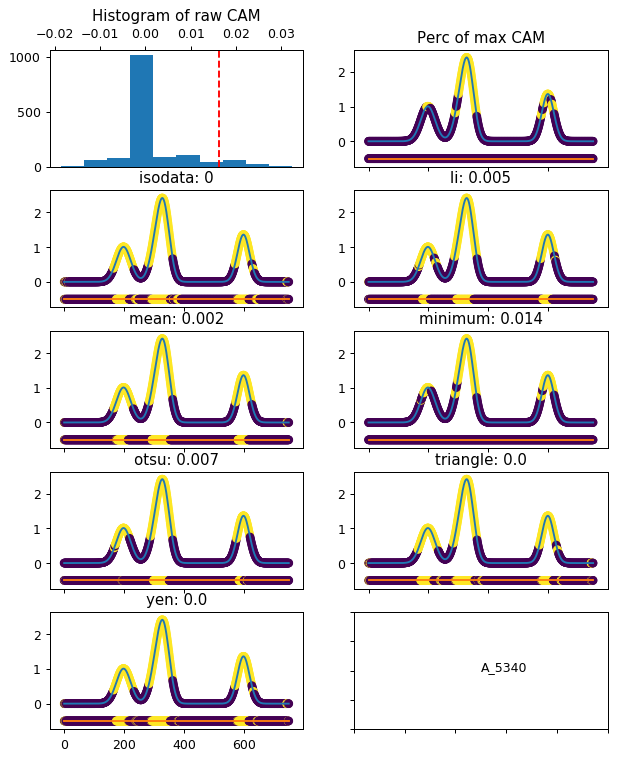

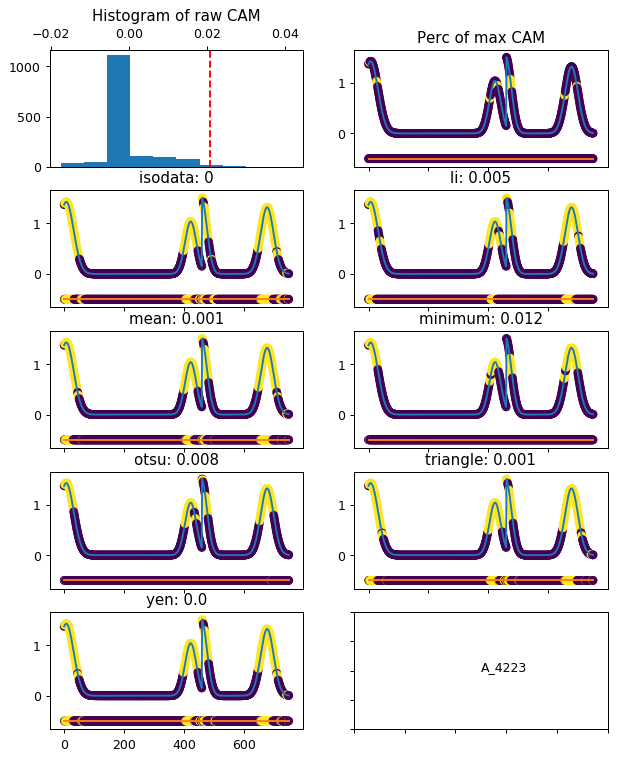

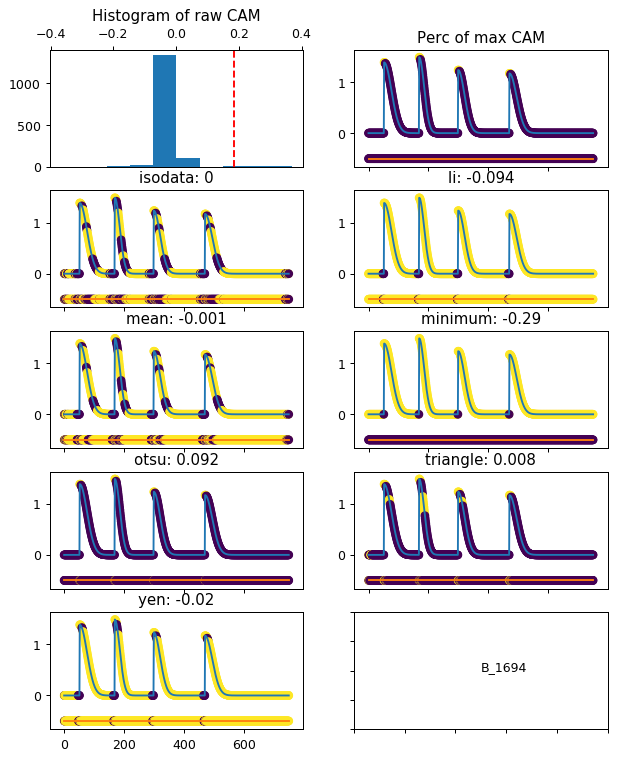

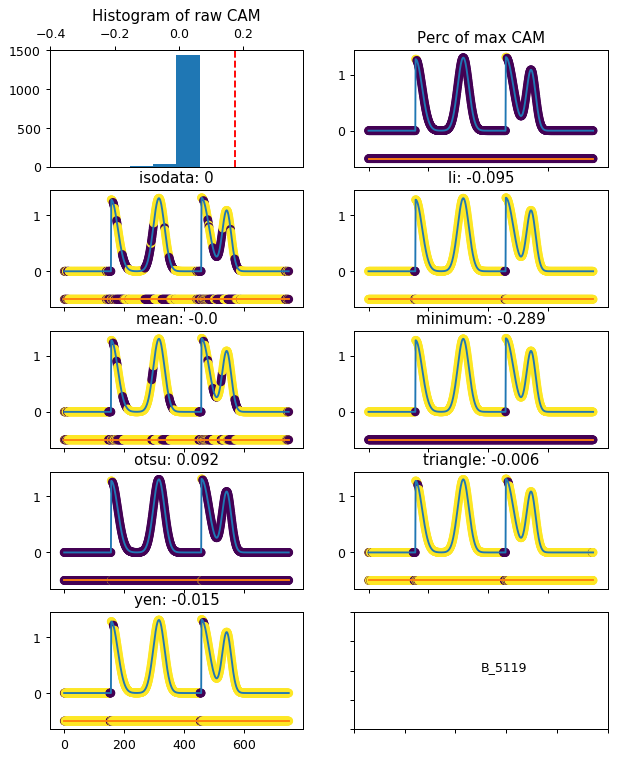

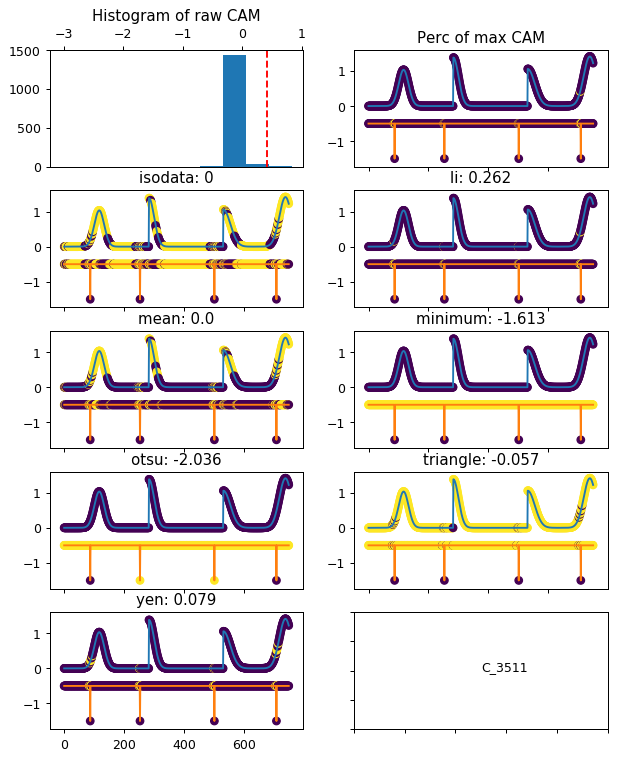

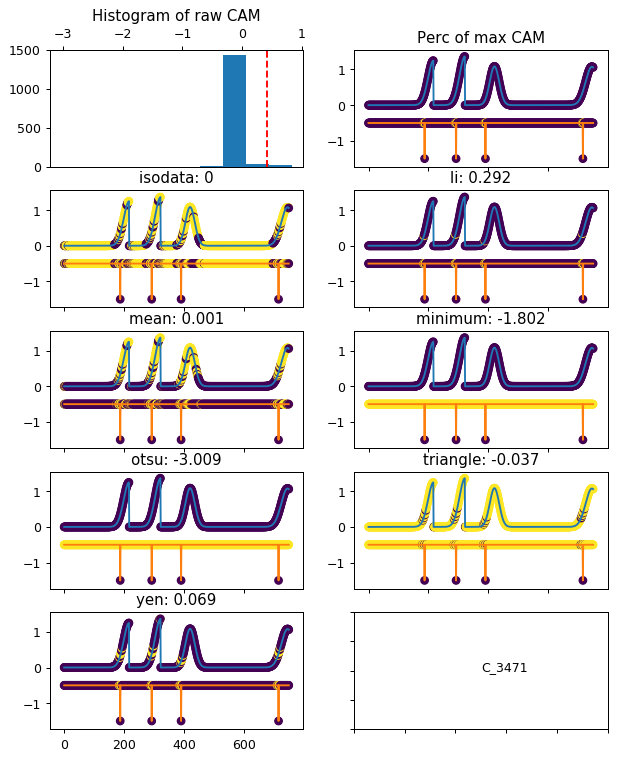

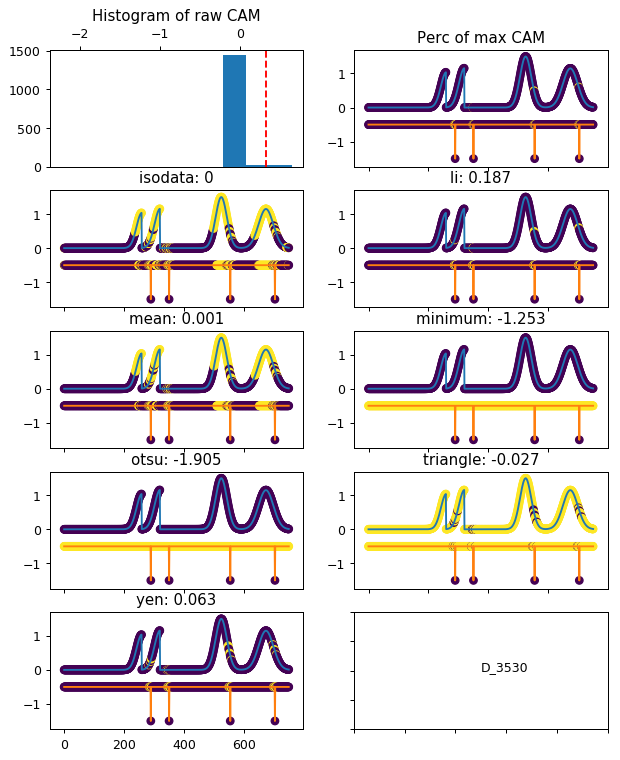

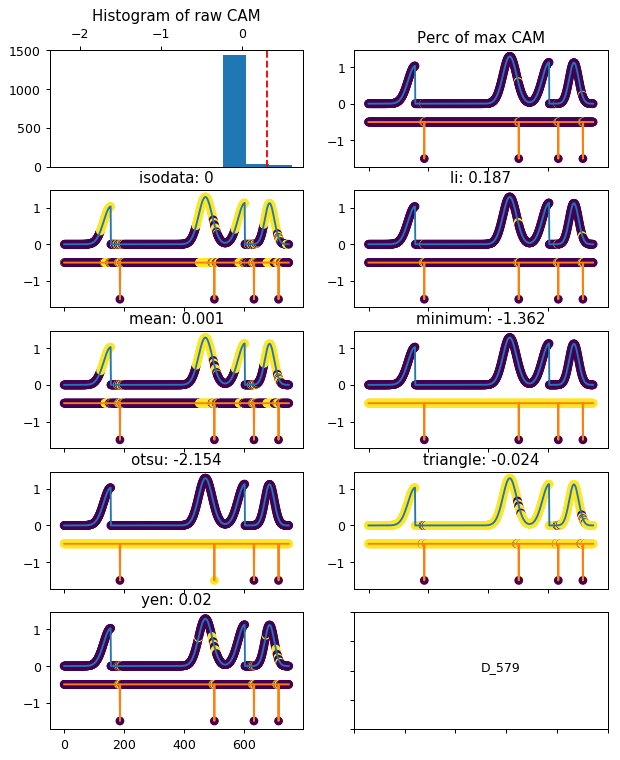

In [13]:
for id in ids:
    thresh_plot2D(bprops[id], all_threshs(bprops[id][0]), id)

In [14]:
ids = ['A_5340', 'A_4223', 'B_1694', 'B_5119', 'C_3511', 'C_3471', 'D_3530', 'D_579']
bprops = {i:both_gbackprop(i, meas_var, use_abs=True) for i in ids}

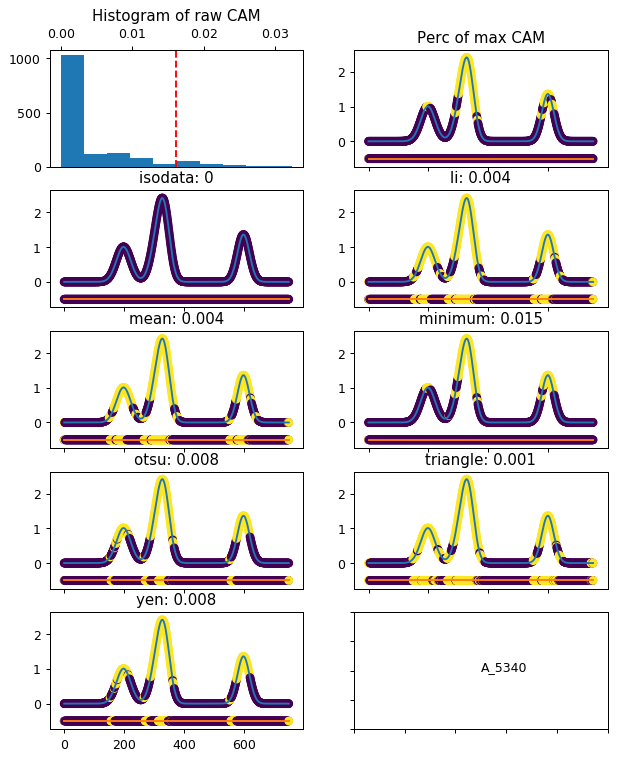

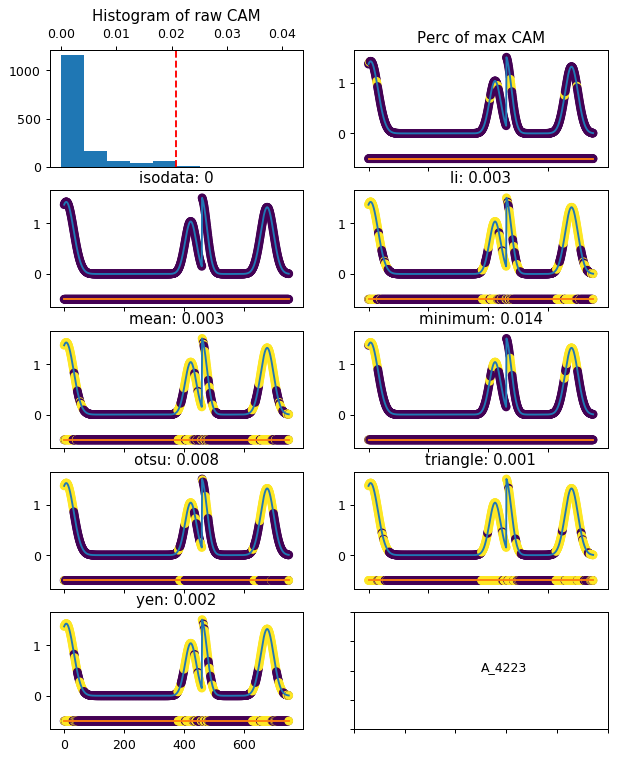

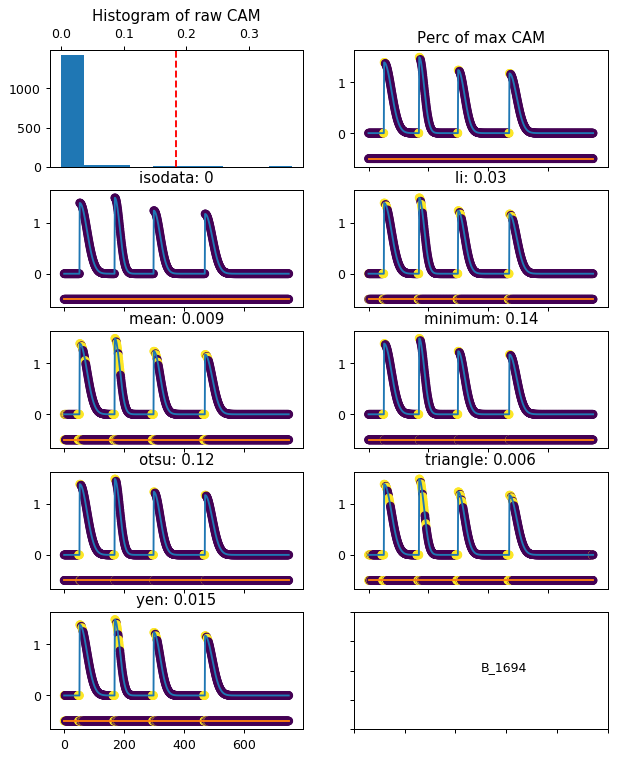

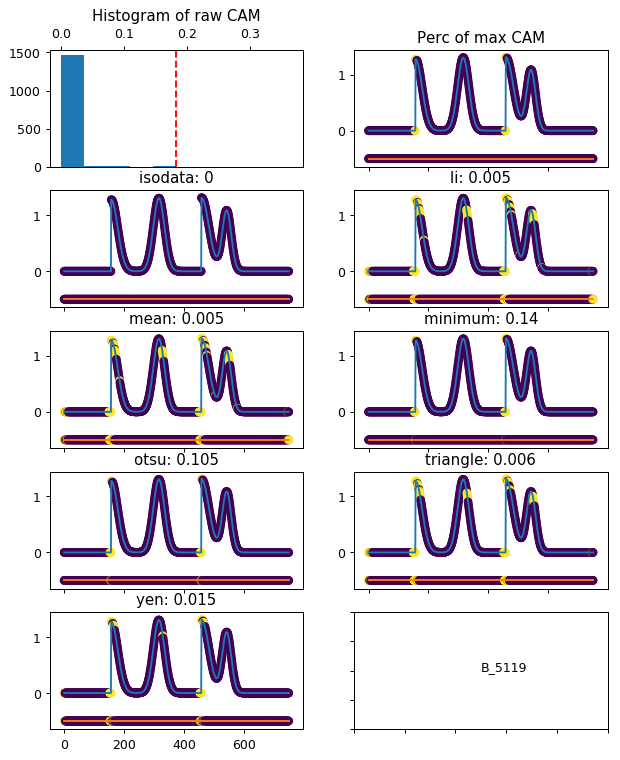

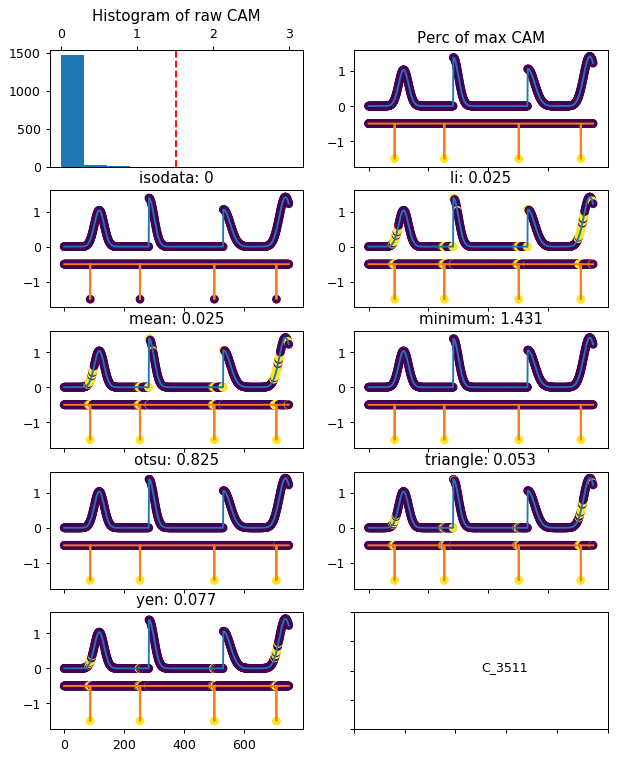

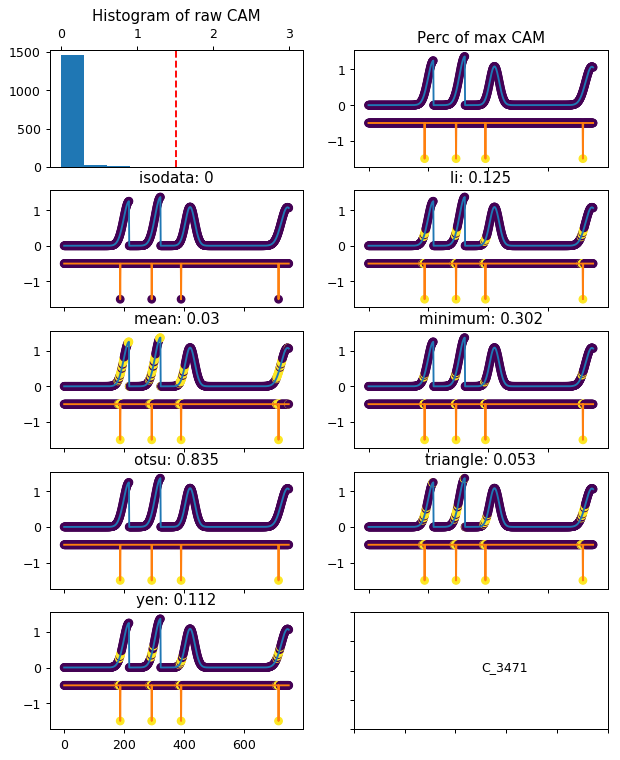

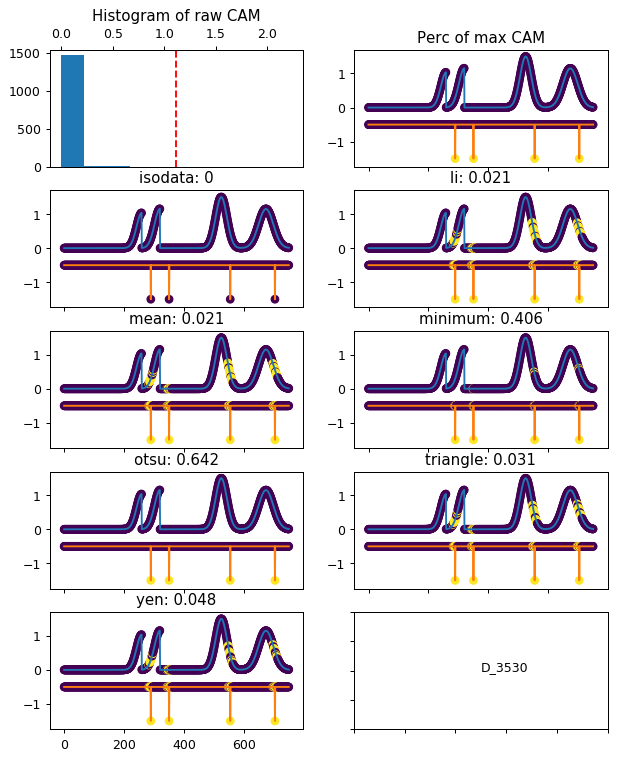

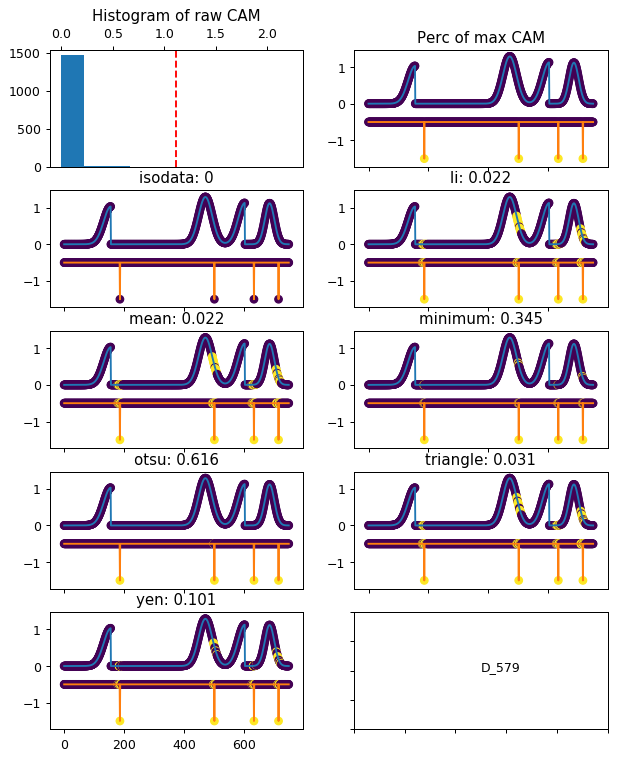

In [15]:
for id in ids:
    thresh_plot2D(bprops[id], all_threshs(bprops[id][0]), id)

### Results Guided Backprop

Results are sharper than CAMs but maps become very sparsed, hard to capture context.

## Test with CAM * guided backprop instead of CAM

In [16]:
def both_gbackCAM(id_traj, meas_var, patt_percmax_sal=0.5, use_abs = True):
    series_numpy = np.array(df.loc[df['ID'] == id_traj][meas_var]).astype('float').squeeze()
    if len(meas_var) >= 2:
        series_numpy = series_numpy.transpose()
    series_tensor = torch.tensor(series_numpy)
    class_trajectory = df.loc[df['ID'] == id_traj]['Class'].iloc[0]  # repeated value through all series
    class_label = classes[class_trajectory]
    cam = create_cam(model, array_series=series_tensor, feature_layer='features',
                         device=device, clip=0, target_class=class_trajectory)
    saliency = create_gbackprop(model=model, array_series=series_tensor,
                         device=device, clip=0, target_class=class_trajectory)
    out = cam * saliency
    if use_abs:
        out = np.abs(out)
    thresh = np.max(out) * patt_percmax_sal
    binout = np.where(out >= thresh, 1, 0)
    return out, binout, thresh, series_numpy

In [17]:
ids = ['A_5340', 'A_4223', 'B_1694', 'B_5119', 'C_3511', 'C_3471', 'D_3530', 'D_579']
guided_cams = {i:both_gbackCAM(i, meas_var, use_abs=True) for i in ids}

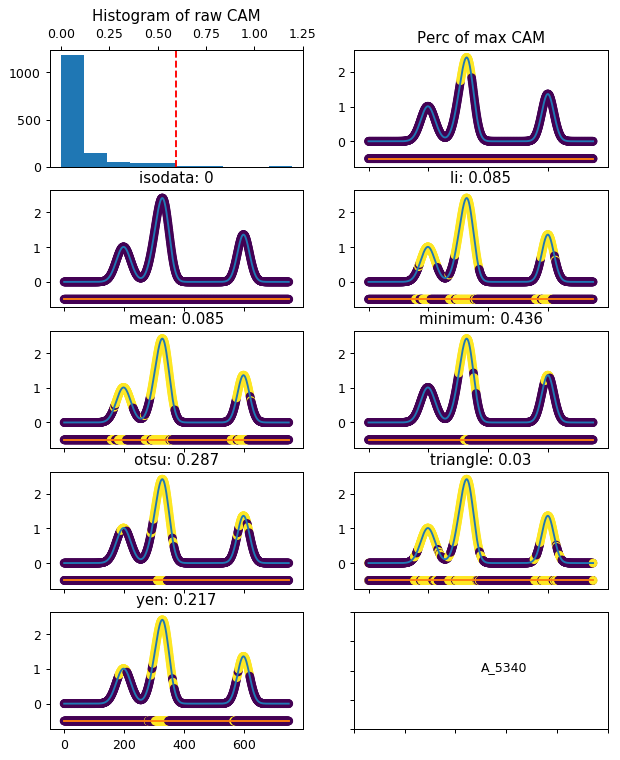

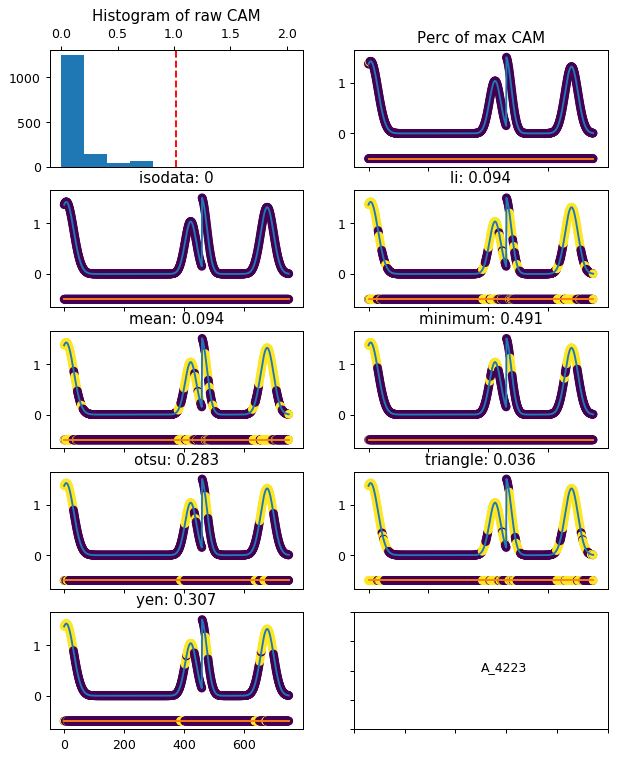

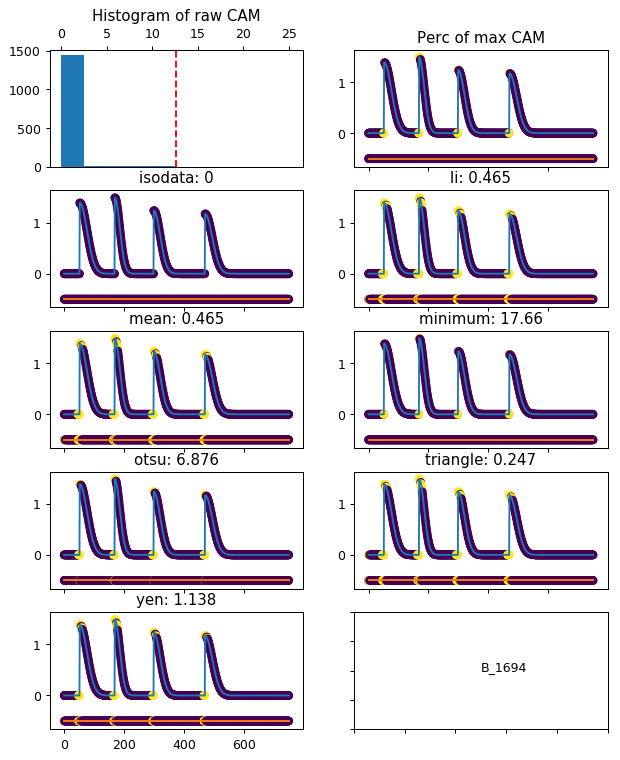

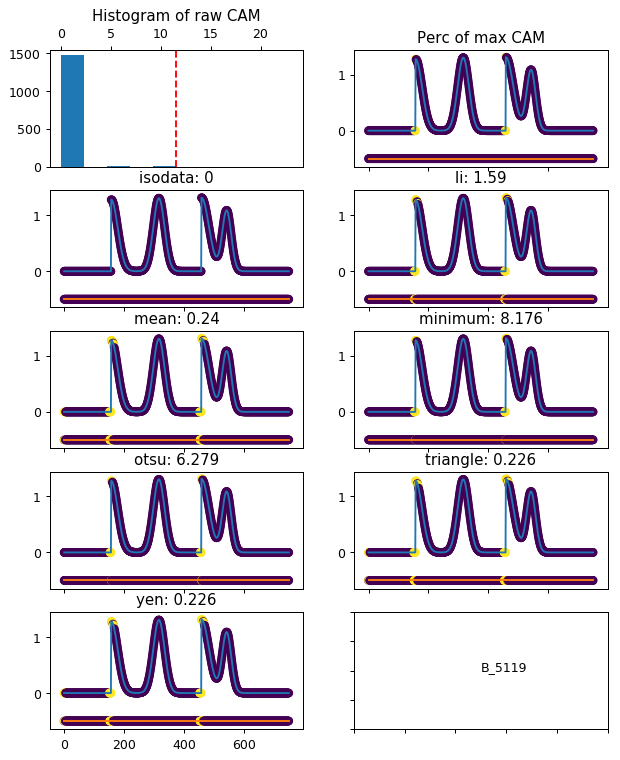

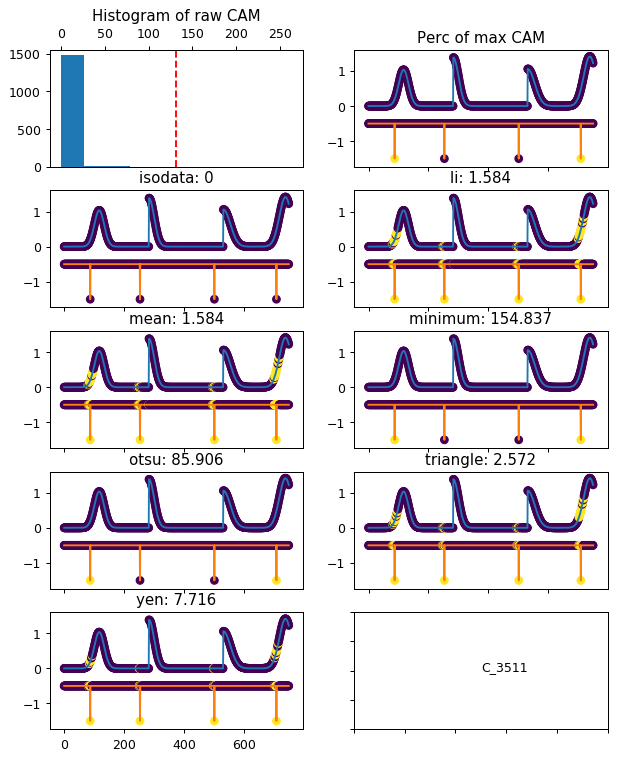

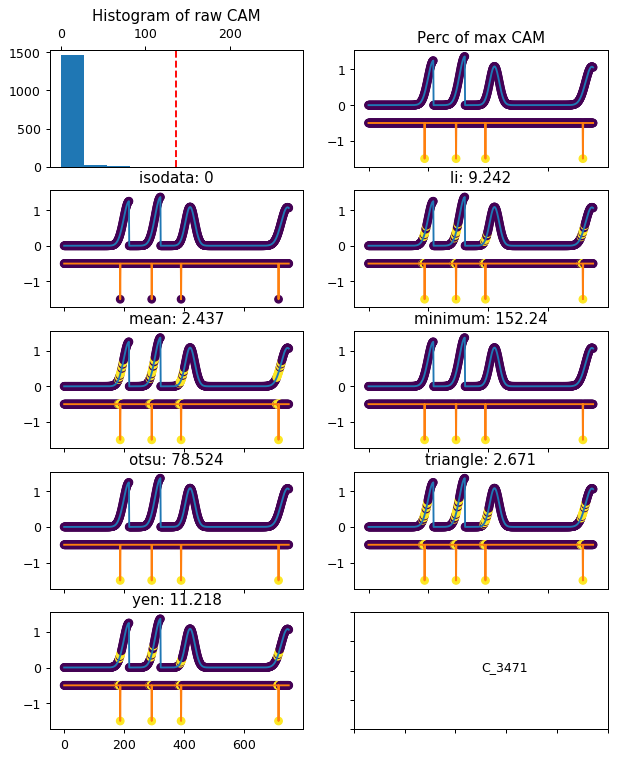

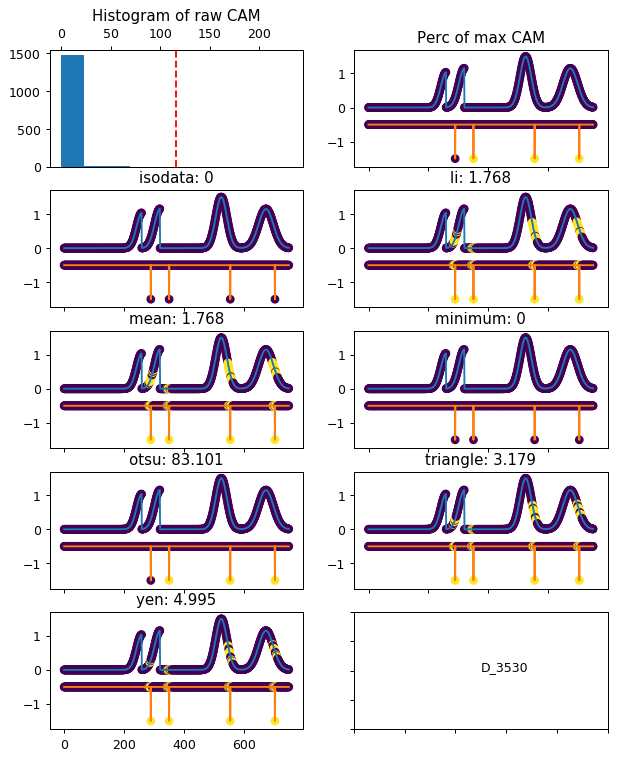

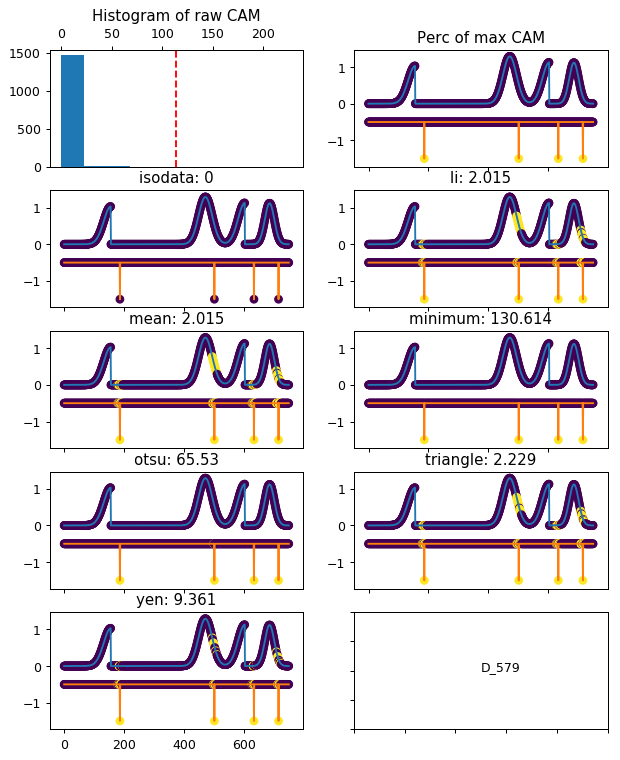

In [18]:
for id in ids:
    thresh_plot2D(guided_cams[id], all_threshs(guided_cams[id][0]), id)

## Use li threshold and compare CAM, guided backprop and guided-CAM

In [22]:
def get_saliencies(id_traj, meas_var, patt_percmax_sal=0.5, use_abs = True):
    series_numpy = np.array(df.loc[df['ID'] == id_traj][meas_var]).astype('float').squeeze()
    if len(meas_var) >= 2:
        series_numpy = series_numpy.transpose()
    series_tensor = torch.tensor(series_numpy)
    class_trajectory = df.loc[df['ID'] == id_traj]['Class'].iloc[0]  # repeated value through all series
    class_label = classes[class_trajectory]
    cam = create_cam(model, array_series=series_tensor, feature_layer='features',
                         device=device, clip=0, target_class=class_trajectory)
    backprop = create_gbackprop(model=model, array_series=series_tensor,
                         device=device, clip=0, target_class=class_trajectory)
    guided_cam = cam * backprop
    if use_abs:
        guided_cam = np.abs(guided_cam)
        
    cam = np.where(cam >= threshold_li(cam), 1, 0)
    backprop = np.where(backprop >= threshold_li(backprop), 1, 0)
    guided_cam = np.where(guided_cam >= threshold_li(guided_cam), 1, 0)
    return cam, backprop, guided_cam, series_numpy, id_traj

def get_saliencies_raw(id_traj, meas_var, patt_percmax_sal=0.5, use_abs = True):
    series_numpy = np.array(df.loc[df['ID'] == id_traj][meas_var]).astype('float').squeeze()
    if len(meas_var) >= 2:
        series_numpy = series_numpy.transpose()
    series_tensor = torch.tensor(series_numpy)
    class_trajectory = df.loc[df['ID'] == id_traj]['Class'].iloc[0]  # repeated value through all series
    class_label = classes[class_trajectory]
    cam = create_cam(model, array_series=series_tensor, feature_layer='features',
                         device=device, clip=0, target_class=class_trajectory)
    backprop = create_gbackprop(model=model, array_series=series_tensor,
                         device=device, clip=0, target_class=class_trajectory)
    guided_cam = cam * backprop
    if use_abs:
        guided_cam = np.abs(guided_cam)
    return cam, backprop, guided_cam, series_numpy, id_traj

def comp_plot2D(saliencies, id_traj):
    plt.close()
    plt.figure(figsize=(16,4), dpi=90)
    ax = plt.subplot(1,3,1)
    plt.plot(np.arange(750), saliencies[3][0,:])
    plt.scatter(np.arange(750), saliencies[3][0,:], c=saliencies[0][0,:])
    plt.plot(np.arange(750), saliencies[3][1,:])
    plt.scatter(np.arange(750), saliencies[3][1,:], c=saliencies[0][1,:])
    plt.title('CAM: ' + id_traj)
    # --------------------------
    ax = plt.subplot(1,3,2)
    plt.plot(np.arange(750), saliencies[3][0,:])
    plt.scatter(np.arange(750), saliencies[3][0,:], c=saliencies[1][0,:])
    plt.plot(np.arange(750), saliencies[3][1,:])
    plt.scatter(np.arange(750), saliencies[3][1,:], c=saliencies[1][1,:])
    plt.title('Guided Backprop')
    # --------------------------
    ax = plt.subplot(1,3,3)
    plt.plot(np.arange(750), saliencies[3][0,:])
    plt.scatter(np.arange(750), saliencies[3][0,:], c=saliencies[2][0,:])
    plt.plot(np.arange(750), saliencies[3][1,:])
    plt.scatter(np.arange(750), saliencies[3][1,:], c=saliencies[2][1,:])
    plt.title('Guided CAM')
    plt.show()
    
    
def comp_plot2D_raw(saliencies, id_traj):
    plt.close()
    plt.figure(figsize=(16,4), dpi=90)
    
    x = np.arange(750)
    xs = np.tile(x, 2)
    
    ax = plt.subplot(1,3,1)
    colormap = 'jet'
    plt.plot(x, saliencies[3][0,:])
    plt.plot(x, saliencies[3][1,:])
    plt.scatter(xs, saliencies[3].flat, c=saliencies[0].flat, cmap=colormap)
    plt.title('CAM: ' + id_traj)
    # --------------------------
    ax = plt.subplot(1,3,2)
    plt.plot(x, saliencies[3][0,:])
    plt.plot(x, saliencies[3][1,:])
    plt.scatter(xs, saliencies[3].flat, c=saliencies[1].flat, cmap=colormap)
    plt.title('Guided Backprop')
    # --------------------------
    ax = plt.subplot(1,3,3)
    plt.plot(x, saliencies[3][0,:])
    plt.plot(x, saliencies[3][1,:])
    plt.scatter(xs, saliencies[3].flat, c=saliencies[2].flat, cmap=colormap)
    plt.title('Guided CAM')
    plt.show()

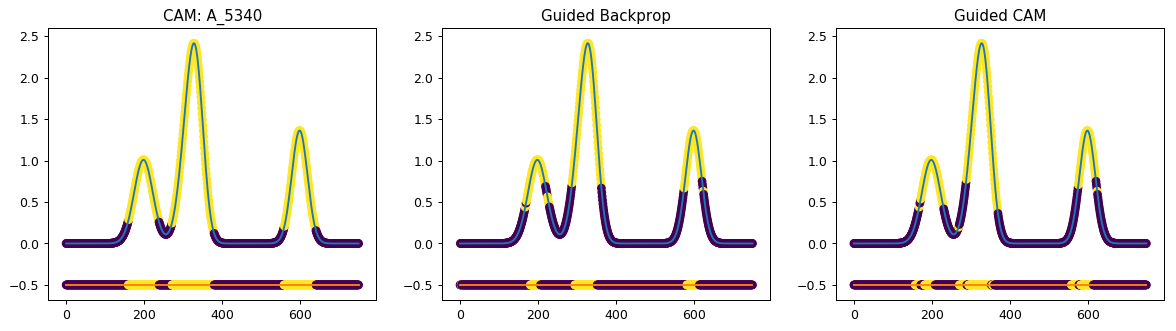

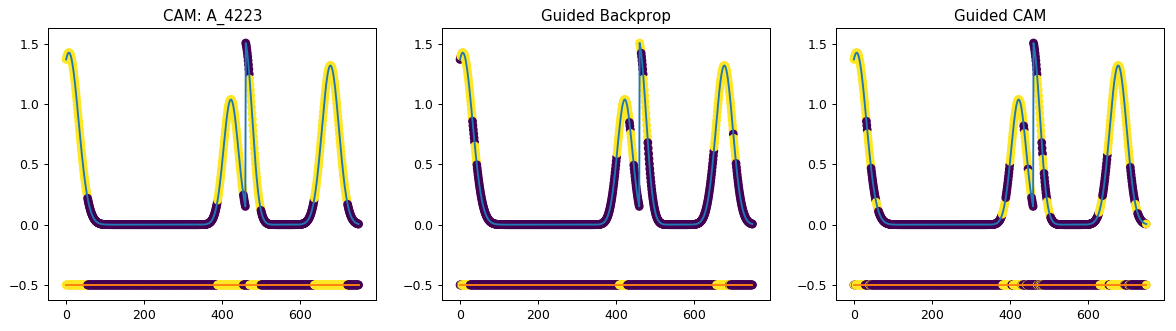

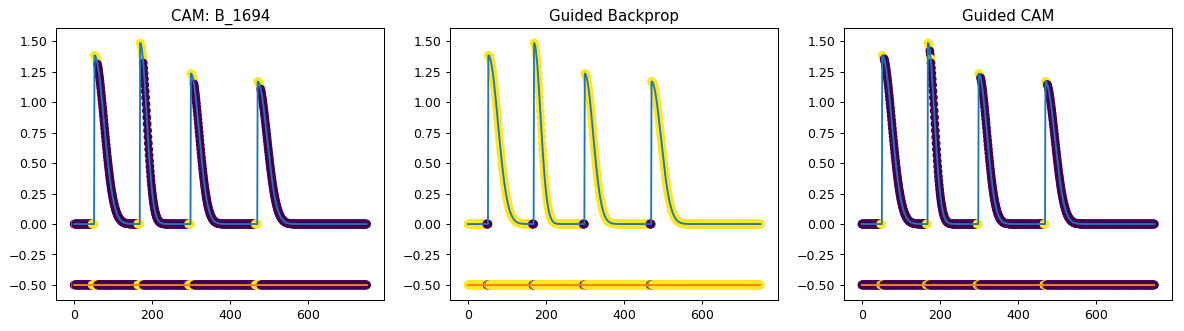

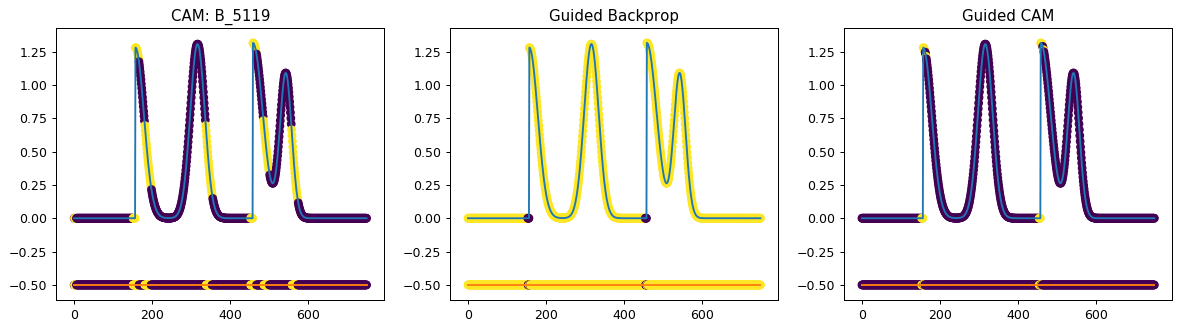

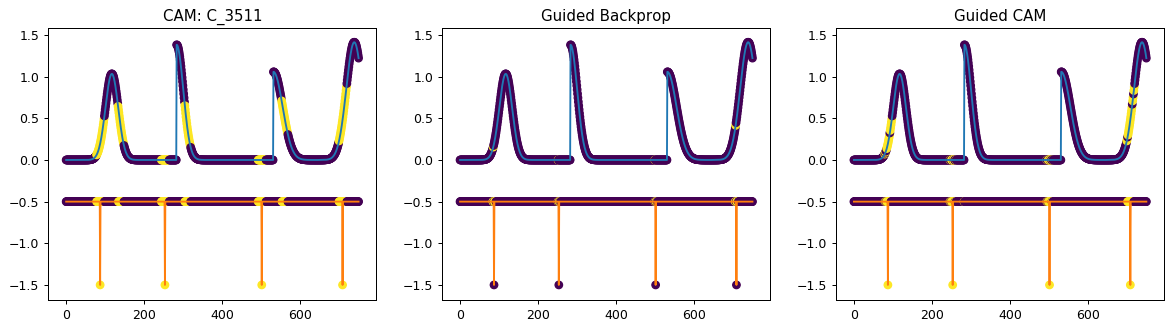

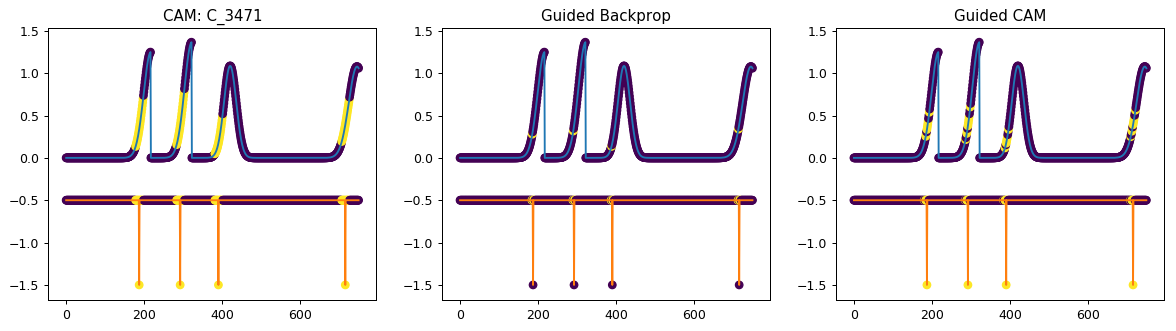

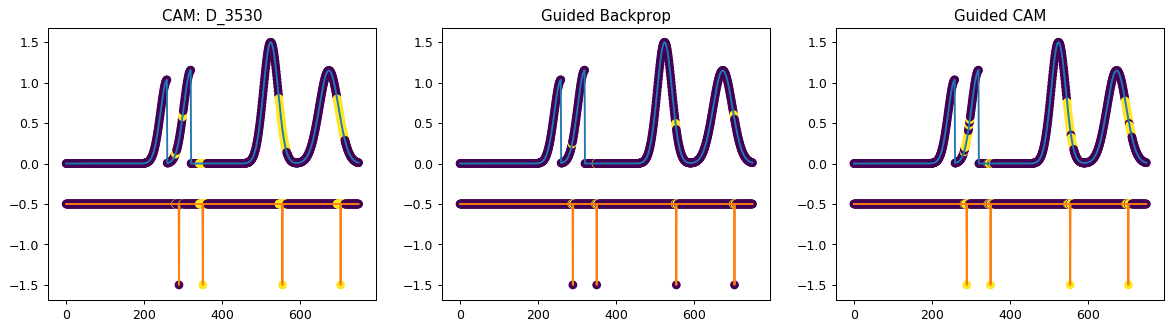

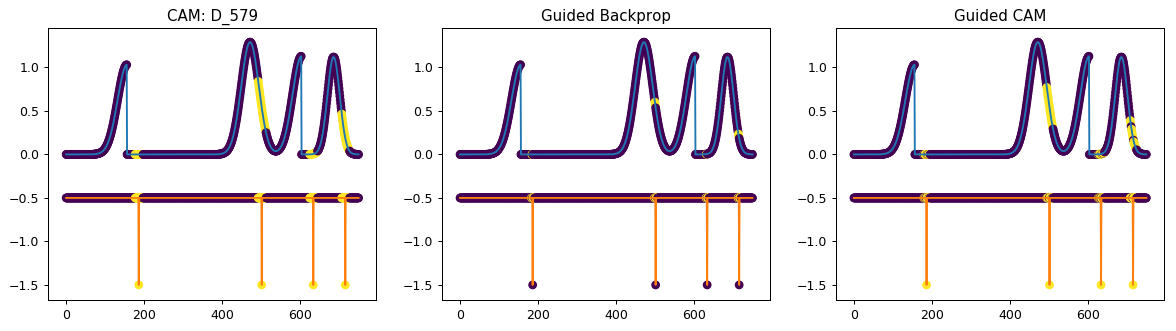

In [20]:
ids = ['A_5340', 'A_4223', 'B_1694', 'B_5119', 'C_3511', 'C_3471', 'D_3530', 'D_579']
saliencies = {i:get_saliencies(i, meas_var, use_abs=True) for i in ids}
for id in ids:
    comp_plot2D(saliencies[id], id)

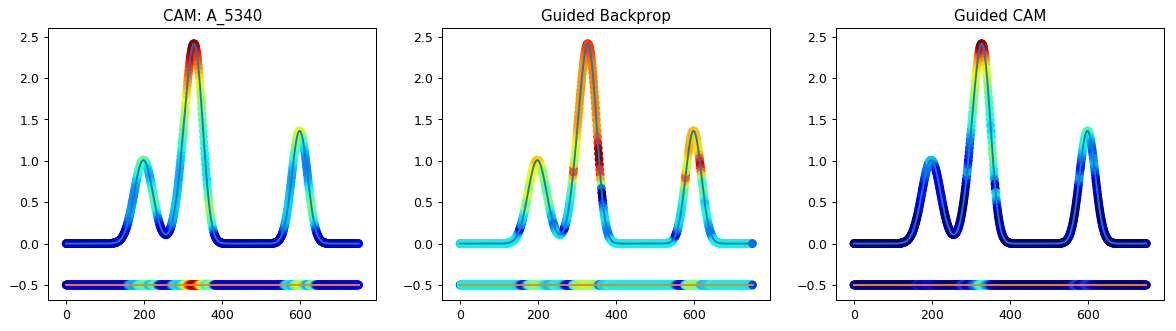

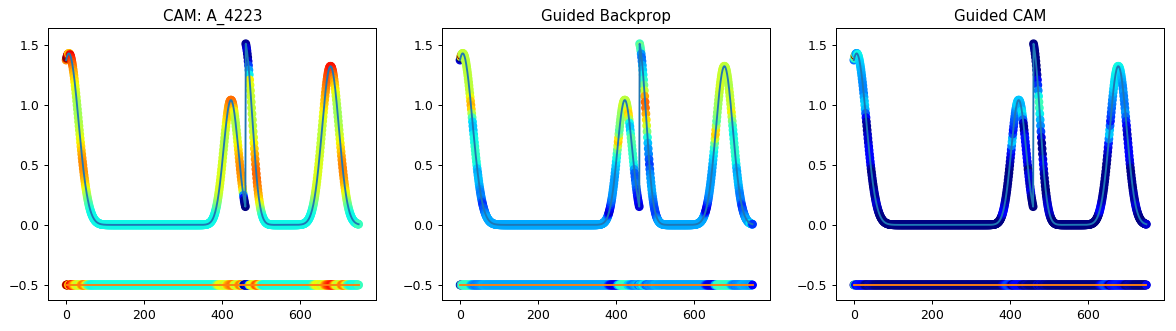

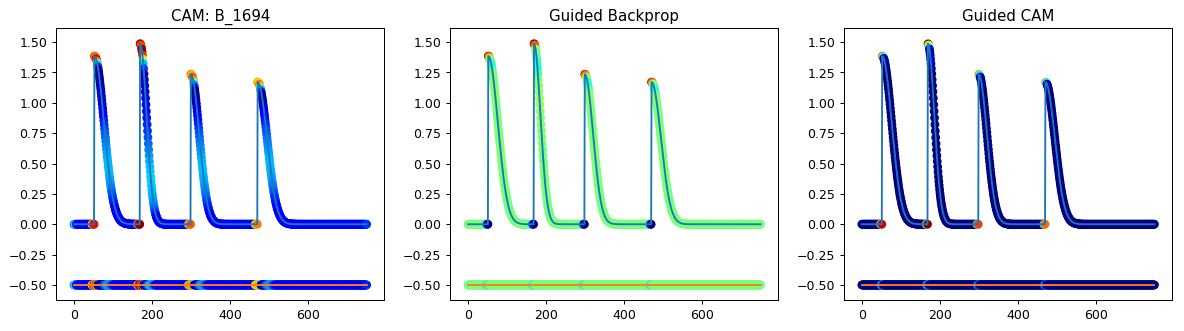

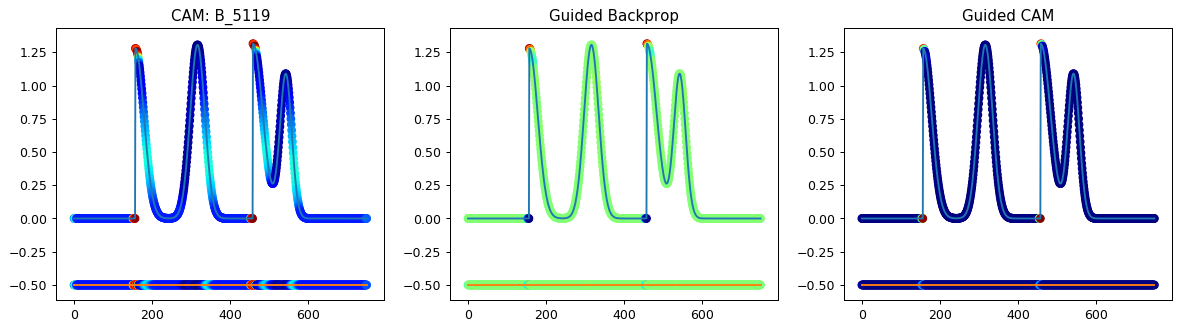

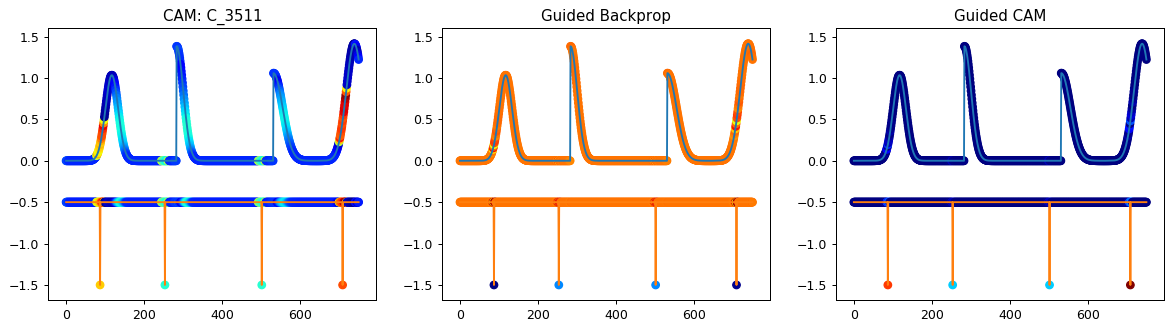

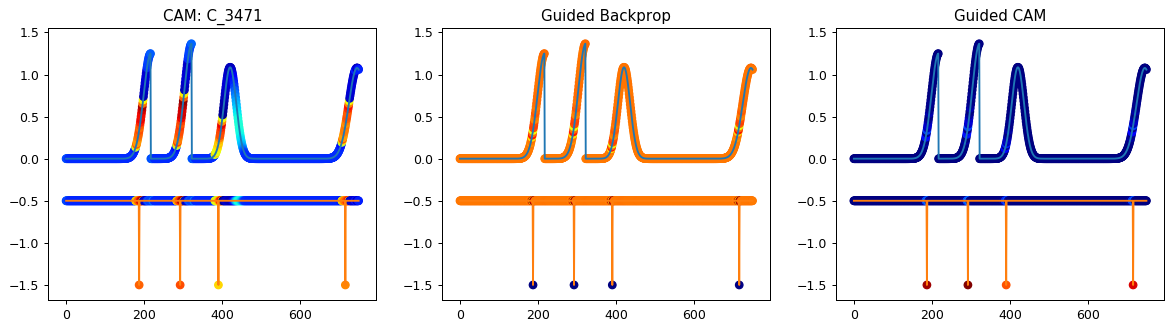

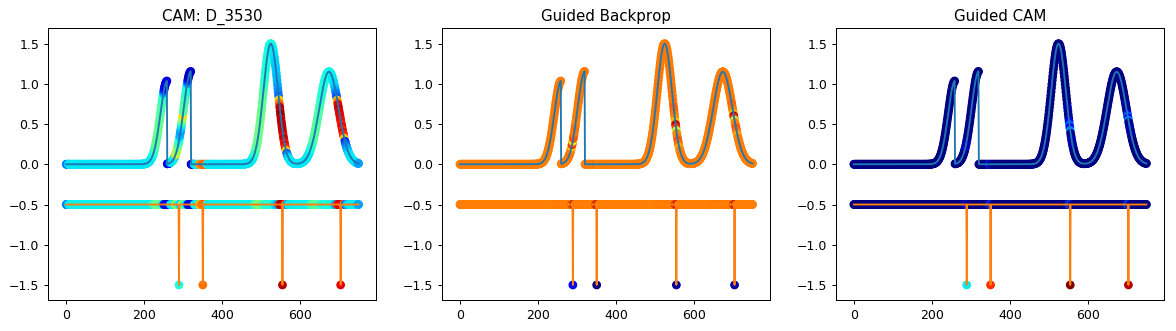

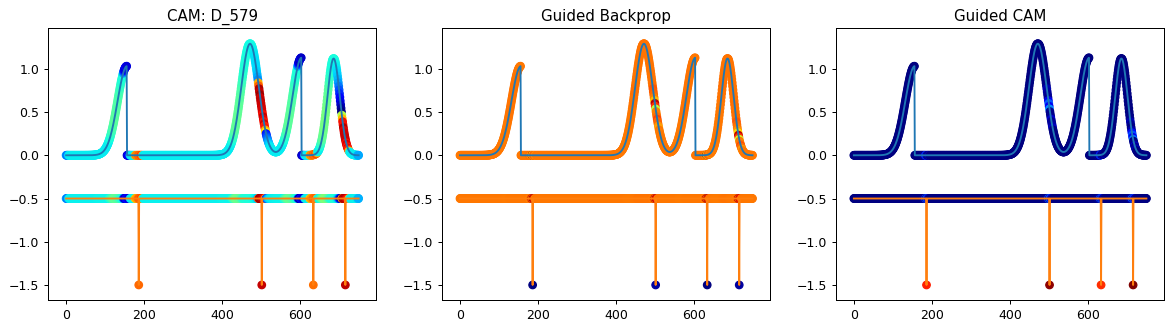

In [23]:
ids = ['A_5340', 'A_4223', 'B_1694', 'B_5119', 'C_3511', 'C_3471', 'D_3530', 'D_579']
saliencies = {i:get_saliencies_raw(i, meas_var, use_abs=True) for i in ids}
for id in ids:
    comp_plot2D_raw(saliencies[id], id)

### Results

Guided CAM returns slightly better patterns in some examples, mostly class B.